<a href="https://colab.research.google.com/github/Bachshot/Problem-Set-2/blob/main/Large_Firms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This was done as a group with my partners Dũng and Thành. Although we used different data sets. Thành helped me on how to guide through the data and code, Dũng helped me refine the new data

In [6]:
import pandas as pd

path = "Large Firms.csv"
df = pd.read_csv(path)
df = pd.read_csv("Large Firms.csv", sep=';')
df.head(5)

,Revenue (d2),Labor (l1),"Variable Cost (n2a, n2e, n2f, n2b)","Investment in new capital (n5a, n5b)",Raw Materials Cost (n2e)
0,15000000000,50,11000000000,1500000000,7000000000
1,15000000000,6,14600000000,11000000000,13000000000
2,15000000000,5,235000000,0,NaN
3,15000000000,12,630000000,0,NaN
4,15000000000,140,6500000000,2500000000,NaN


Successfully loaded data. Mean observed w: 6499.4190
Median scaled Revenue: 60.00 (billions VND)
Initializing Firm Dynamic Profit Maximization Model.
Using w (cost per unit of labor, in billions VND): 6499.4190
Capital grid: [0.00, 90.00] with 50 points.

Solving the firm's problem using VFI...
Solved period t = 39
Solved period t = 38
Solved period t = 37
Solved period t = 36
Solved period t = 35
Solved period t = 34
Solved period t = 33
Solved period t = 32
Solved period t = 31
Solved period t = 30
Solved period t = 29
Solved period t = 28
Solved period t = 27
Solved period t = 26
Solved period t = 25
Solved period t = 24
Solved period t = 23
Solved period t = 22
Solved period t = 21
Solved period t = 20
Solved period t = 19
Solved period t = 18
Solved period t = 17
Solved period t = 16
Solved period t = 15
Solved period t = 14
Solved period t = 13
Solved period t = 12
Solved period t = 11
Solved period t = 10
Solved period t = 9
Solved period t = 8
Solved period t = 7
Solved period 

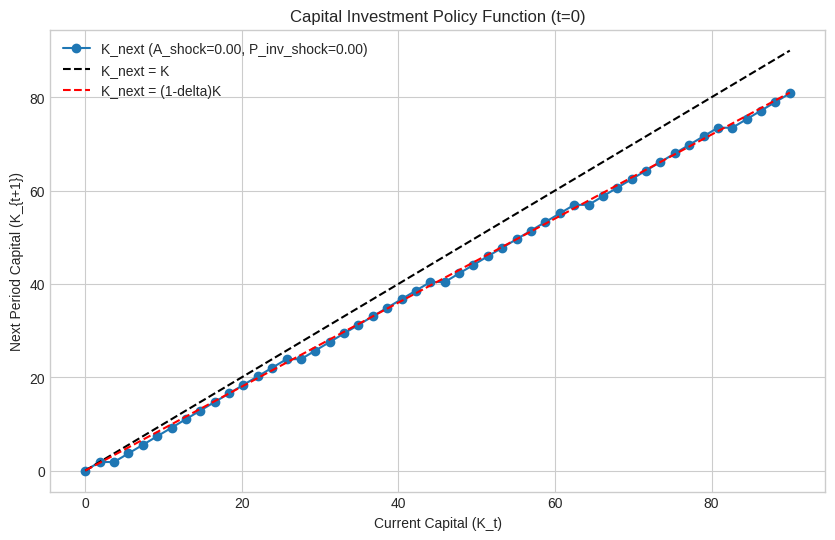

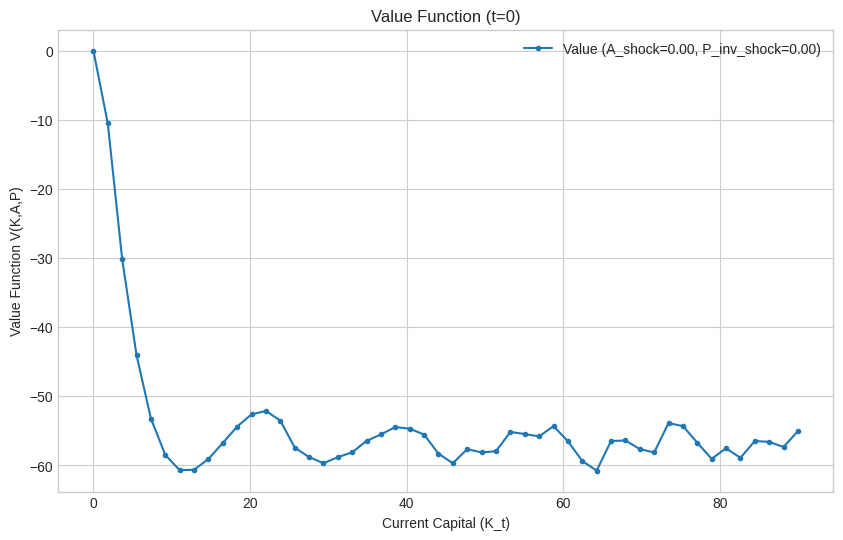

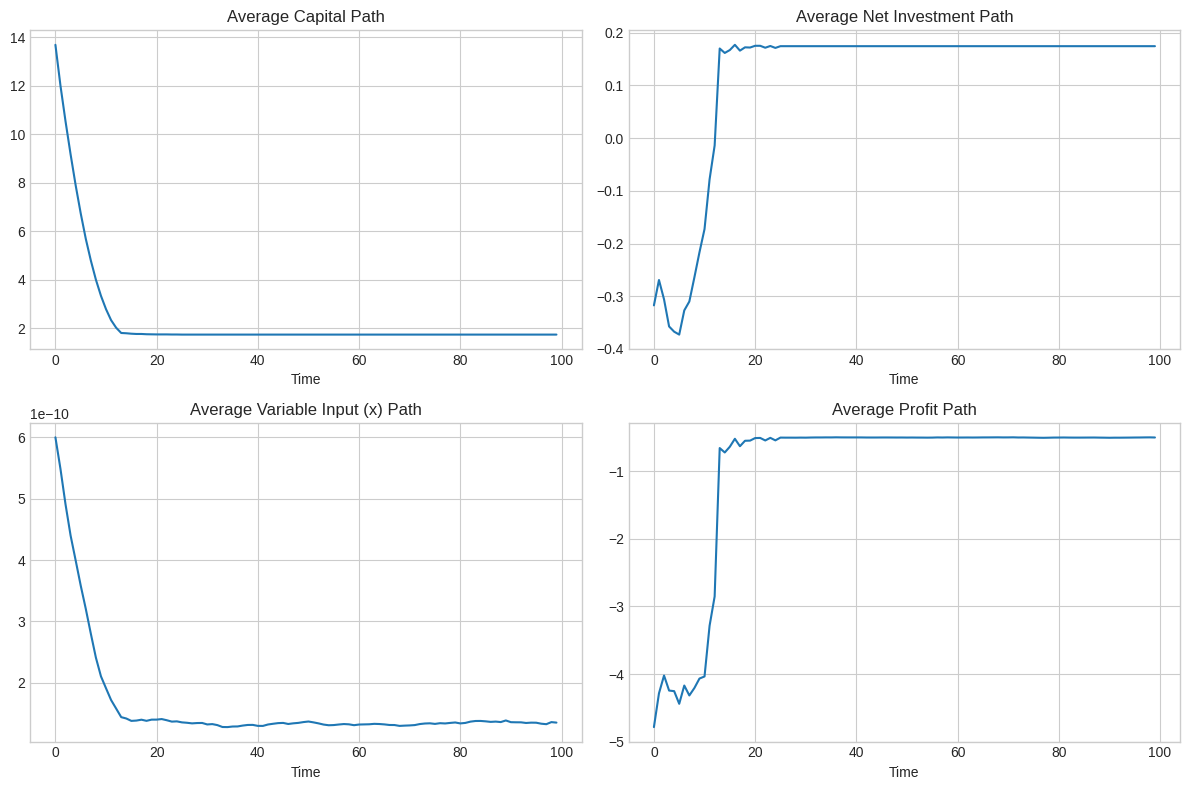

In [7]:
import pandas as pd
import numpy as np
from scipy import stats
from types import SimpleNamespace
import time
from numpy.linalg import matrix_power
import matplotlib.pyplot as plt

# --- Data Loading and Preprocessing ---
def clean_currency_value(value_str):
    """Cleans a numeric string (potentially with commas) to a float."""
    if pd.isna(value_str) or value_str == '#REF!':
        return np.nan
    if isinstance(value_str, (int, float)):
        return float(value_str)

    cleaned = str(value_str).replace(',', '').strip()
    if not cleaned:
        return np.nan
    try:
        return float(cleaned)
    except ValueError:
        return np.nan

def load_and_preprocess_data(path):
    """Loads and preprocesses the Large Firms data."""
    try:
        # Use utf-8-sig to handle potential BOM
        df = pd.read_csv(path, encoding='utf-8-sig', sep=';')
    except FileNotFoundError:
        print(f"Error: The file {path} was not found.")
        return None

    # Clean column names (remove BOM from first column if present)
    df.columns = df.columns.str.replace('^\ufeff', '', regex=True)

    # Select and clean relevant columns
    cols_to_clean = ['Revenue (d2)', 'Variable Cost (n2a, n2e, n2f, n2b)', 'Investment in new capital (n5a, n5b)']
    for col in cols_to_clean:
        if col in df.columns:
            df[col] = df[col].apply(clean_currency_value)
        else:
            print(f"Warning: Column {col} not found in CSV.")
            df[col] = np.nan # Add as NaN column if missing

    labor_col_name = 'Labor (l1)'
    if labor_col_name in df.columns:
        # Ensure Labor is numeric, coercing errors to NaN
        df['Labor (l1)'] = pd.to_numeric(df[labor_col_name], errors='coerce') # Keep original code's internal name
    else:
        print(f"Warning: Column {labor_col_name} not found in CSV.")
        df['Labor (l1)'] = np.nan

    # Drop rows where essential data for 'w' calculation is missing or invalid
    df.dropna(subset=['Variable Cost (n2a, n2e, n2f, n2b)', 'Labor (l1)'], inplace=True)
    df = df[df['Labor (l1)'] > 0] # Avoid division by zero for w


    scale_factor = 1e9
    df['Variable cost_scaled'] = df['Variable Cost (n2a, n2e, n2f, n2b)'] / scale_factor
    df['Revenue_scaled'] = df['Revenue (d2)'] / scale_factor
    df['Investment_scaled'] = df['Investment in new capital (n5a, n5b)'] / scale_factor

    # w is cost per unit of labor, so (Total Var Cost / Labor).
    # If Var Cost is scaled, w will be in (billions VND / unit of labor)
    df['w_observed'] = df['Variable cost_scaled'] / df['Labor (l1)']

    # Filter out extreme or invalid w values
    df = df[df['w_observed'] > 0]
    df = df[np.isfinite(df['w_observed'])]

    if df.empty:
        print("Error: No valid data remaining after preprocessing to calculate 'w'.")
        return None

    return df

# --- Tauchen's Method (from original code, slightly adapted) ---
def tauchen(mu, rho, sigma_eps, n_points, m_std_devs):
    uncond_mean = mu / (1.0 - rho)
    uncond_std_dev = sigma_eps / np.sqrt(1.0 - rho**2)
    z_max = uncond_mean + m_std_devs * uncond_std_dev
    z_min = uncond_mean - m_std_devs * uncond_std_dev
    z_grid = np.linspace(z_min, z_max, n_points)
    step_size = (z_max - z_min) / (n_points - 1)
    P = np.zeros((n_points, n_points))
    for i in range(n_points):
        for j in range(n_points):
            mean_next_z = mu + rho * z_grid[i]
            if j == 0:
                P[i, j] = stats.norm.cdf((z_grid[j] - mean_next_z + step_size / 2.0) / sigma_eps)
            elif j == n_points - 1:
                P[i, j] = 1.0 - stats.norm.cdf((z_grid[j] - mean_next_z - step_size / 2.0) / sigma_eps)
            else:
                P[i, j] = (stats.norm.cdf((z_grid[j] - mean_next_z + step_size / 2.0) / sigma_eps) -
                           stats.norm.cdf((z_grid[j] - mean_next_z - step_size / 2.0) / sigma_eps))
    return z_grid, P

#Firm Model Class
class FirmModel:
    def __init__(self):
        print("Initializing Firm Dynamic Profit Maximization Model.")
        self.par = SimpleNamespace()
        self.sol = SimpleNamespace()
        self.sim = SimpleNamespace()

    def setup_parameters(self, data_df, **kwargs):
        par = self.par
        par.beta = kwargs.get('beta', 0.96)
        par.delta = kwargs.get('delta', 0.10)
        par.alpha = kwargs.get('alpha', 0.30)
        par.nu = kwargs.get('nu', 0.60)
        par.gamma = kwargs.get('gamma', 20.0)

        if data_df is not None and 'w_observed' in data_df and not data_df['w_observed'].empty:
            par.w = data_df['w_observed'].mean()
        else:
            par.w = kwargs.get('w', 0.05)
        print(f"Using w (cost per unit of labor, in billions VND): {par.w:.4f}")

        par.A_base = kwargs.get('A_base', 1.0)
        par.rho_A = kwargs.get('rho_A', 0.90)
        par.sigma_A = kwargs.get('sigma_A', 0.07)
        par.z_n_points = kwargs.get('z_n_points', 5)

        par.P_base = kwargs.get('P_base', 1.0)
        par.rho_P = kwargs.get('rho_P', 0.80)
        par.sigma_P = kwargs.get('sigma_P', 0.10)
        par.q_n_points = kwargs.get('q_n_points', 5)
        par.tauchen_m = kwargs.get('tauchen_m', 2)

        default_k_max = 50.0
        if data_df is not None and 'Revenue_scaled' in data_df and par.alpha > 0:
            median_rev_scaled = data_df['Revenue_scaled'].median()
            if pd.notna(median_rev_scaled) and median_rev_scaled > 0:
                 k_max_from_data = median_rev_scaled * 1.5
                 par.k_max = max(k_max_from_data, default_k_max)
            else:
                 par.k_max = default_k_max
        else:
            par.k_max = default_k_max

        par.k_min = kwargs.get('k_min', 1e-6) # Ensure k_min is slightly positive for K^alpha
        par.k_n_points = kwargs.get('k_n_points', 50)
        par.k_grid = np.linspace(par.k_min, par.k_max, par.k_n_points)
        print(f"Capital grid: [{par.k_min:.2f}, {par.k_max:.2f}] with {par.k_n_points} points.")

        par.T_firm = kwargs.get('T_firm', 40)
        par.z_grid, par.P_z = tauchen(mu=0, rho=par.rho_A, sigma_eps=par.sigma_A,
                                      n_points=par.z_n_points, m_std_devs=par.tauchen_m)
        par.q_grid, par.P_q = tauchen(mu=0, rho=par.rho_P, sigma_eps=par.sigma_P,
                                      n_points=par.q_n_points, m_std_devs=par.tauchen_m)
        assert 0 < par.beta < 1
        assert 0 < par.delta < 1
        assert 0 < par.alpha < 1
        assert 0 < par.nu < 1
        assert par.w > 0, "Variable input cost 'w' must be positive."

    def define_firm_functions(self):
        par = self.par

        #CORRECTED AND VECTORIZED optimal_x
        def optimal_x(A_val_in, K_val_in, w_val_scalar):
            A_val = np.asarray(A_val_in)
            K_val = np.asarray(K_val_in)
            res_shape = np.broadcast(A_val, K_val).shape
            x_star_values = np.zeros(res_shape, dtype=float)

            # Mask for where K and A are positive enough for calculation
            mask_inputs_positive = (K_val > 1e-12) & (A_val > 1e-12)

            if np.any(mask_inputs_positive):
                K_m = K_val[mask_inputs_positive]
                A_m = A_val[mask_inputs_positive]

                K_pow_alpha_m = np.power(K_m, par.alpha)
                # Calculate base only for these positive K and A
                base_m = (par.nu * A_m * K_pow_alpha_m) / w_val_scalar

                # Mask for where this calculated base is positive
                mask_base_positive = base_m > 1e-12

                if np.any(mask_base_positive):
                    # Calculate x* only for positive base
                    x_star_positive_base = np.power(base_m[mask_base_positive], 1.0 / (1.0 - par.nu))

                    # Create a temporary array for base_m expanded to full shape
                    temp_base_full_shape = np.full(res_shape, -1.0, dtype=float) # Init with non-positive
                    temp_base_full_shape[mask_inputs_positive] = base_m # Fill in calculated base_m

                    # Final mask is where inputs were positive AND the calculated base was positive
                    final_assignment_mask = mask_inputs_positive & (temp_base_full_shape > 1e-12)

                    if np.any(final_assignment_mask): # Re-check if any element satisfies final_assignment_mask
                         x_star_values[final_assignment_mask] = np.power(temp_base_full_shape[final_assignment_mask], 1.0 / (1.0 - par.nu))

            # Return scalar if inputs were scalar
            if np.isscalar(A_val_in) and np.isscalar(K_val_in):
                return x_star_values.item()
            return x_star_values

        #CORRECTED AND VECTORIZED variable_profit
        def variable_profit(A_val_in, K_val_in, w_val_scalar):
            A_val = np.asarray(A_val_in)
            K_val = np.asarray(K_val_in)
            res_shape = np.broadcast(A_val, K_val).shape
            profit_values = np.zeros(res_shape, dtype=float)

            # optimal_x is now vectorized and handles scalar/array inputs
            x_s = self.par.optimal_x(A_val, K_val, w_val_scalar)

            # Mask for where K, A, and x_star are all positive for profit calculation
            mask_profit_calculable = (K_val > 1e-12) & (A_val > 1e-12) & (x_s > 1e-12)

            if np.any(mask_profit_calculable):
                # Select only the elements where profit calculation is valid
                K_m = K_val[mask_profit_calculable]
                A_m = A_val[mask_profit_calculable]
                x_m = x_s[mask_profit_calculable] # x_s is already an array from optimal_x

                K_pow_alpha_m = np.power(K_m, par.alpha)
                x_pow_nu_m = np.power(x_m, par.nu)

                revenue_m = A_m * K_pow_alpha_m * x_pow_nu_m
                cost_x_m = w_val_scalar * x_m

                profit_values[mask_profit_calculable] = revenue_m - cost_x_m

            if np.isscalar(A_val_in) and np.isscalar(K_val_in):
                return profit_values.item()
            return profit_values

        self.par.optimal_x = optimal_x
        self.par.variable_profit = variable_profit

    def solve_vfi(self):
        par = self.par
        sol = self.sol
        sol.V = np.full((par.k_n_points, par.z_n_points, par.q_n_points, par.T_firm), -np.inf)
        sol.K_next_policy = np.zeros((par.k_n_points, par.z_n_points, par.q_n_points, par.T_firm))
        sol.x_policy = np.zeros((par.k_n_points, par.z_n_points, par.q_n_points, par.T_firm))

        A_shocks = par.A_base * np.exp(par.z_grid)
        P_inv_shocks = par.P_base * np.exp(par.q_grid)

        t = par.T_firm - 1
        for k_idx, K_val in enumerate(par.k_grid):
            for z_idx, z_val in enumerate(par.z_grid):
                A_val = A_shocks[z_idx]
                # Pass scalar par.w
                current_var_profit = par.variable_profit(A_val, K_val, par.w)
                sol.x_policy[k_idx, z_idx, :, t] = par.optimal_x(A_val, K_val, par.w)

                for q_idx, q_val in enumerate(par.q_grid):
                    P_inv_val = P_inv_shocks[q_idx]
                    best_val_for_state = -np.inf
                    chosen_K_next_for_state = par.k_grid[0]
                    for k_next_idx, K_next_val in enumerate(par.k_grid):
                        net_investment = K_next_val - (1 - par.delta) * K_val
                        adj_cost = (par.gamma / 2.0) * (net_investment**2)
                        inv_cost = P_inv_val * net_investment
                        current_total_profit = current_var_profit - adj_cost - inv_cost
                        if current_total_profit > best_val_for_state:
                            best_val_for_state = current_total_profit
                            chosen_K_next_for_state = K_next_val
                    sol.V[k_idx, z_idx, q_idx, t] = best_val_for_state
                    sol.K_next_policy[k_idx, z_idx, q_idx, t] = chosen_K_next_for_state
        print(f"Solved period t = {t}")

        for t in reversed(range(par.T_firm - 1)):
            V_next_period = sol.V[:, :, :, t + 1]
            EV_sum_over_q_next = np.tensordot(V_next_period, par.P_q, axes=([2],[1]))
            EV_next_final = np.tensordot(EV_sum_over_q_next, par.P_z, axes=([1],[1]))

            for k_idx, K_val in enumerate(par.k_grid):
                for z_idx, z_val in enumerate(par.z_grid):
                    A_val = A_shocks[z_idx]
                    current_var_profit = par.variable_profit(A_val, K_val, par.w) # Pass scalar par.w
                    sol.x_policy[k_idx, z_idx, :, t] = par.optimal_x(A_val, K_val, par.w)
                    for q_idx, q_val in enumerate(par.q_grid):
                        P_inv_val = P_inv_shocks[q_idx]
                        max_value_for_state = -np.inf
                        policy_K_next_for_state = par.k_grid[0]
                        for k_next_idx, K_next_val in enumerate(par.k_grid):
                            net_investment = K_next_val - (1.0 - par.delta) * K_val
                            adj_cost = (par.gamma / 2.0) * (net_investment**2)
                            inv_cost = P_inv_val * net_investment
                            expected_future_V = EV_next_final[k_next_idx, z_idx, q_idx]
                            current_objective = current_var_profit - adj_cost - inv_cost + par.beta * expected_future_V
                            if current_objective > max_value_for_state:
                                max_value_for_state = current_objective
                                policy_K_next_for_state = K_next_val
                        sol.V[k_idx, z_idx, q_idx, t] = max_value_for_state
                        sol.K_next_policy[k_idx, z_idx, q_idx, t] = policy_K_next_for_state
            print(f"Solved period t = {t}")

    def simulate_paths(self, n_firms=1000, sim_periods=60):
        par = self.par
        sol = self.sol
        sim = self.sim

        sim.K_path = np.zeros((n_firms, sim_periods))
        sim.A_path = np.zeros((n_firms, sim_periods))
        sim.P_inv_path = np.zeros((n_firms, sim_periods))
        sim.x_path = np.zeros((n_firms, sim_periods))
        sim.I_path = np.zeros((n_firms, sim_periods))
        sim.Profit_path = np.zeros((n_firms, sim_periods))

        initial_k_idx = np.random.choice(par.k_n_points//3, size=n_firms)
        P_z_stat = matrix_power(par.P_z, 200)[0, :]
        P_q_stat = matrix_power(par.P_q, 200)[0, :]
        initial_z_idx = np.random.choice(par.z_n_points, size=n_firms, p=P_z_stat)
        initial_q_idx = np.random.choice(par.q_n_points, size=n_firms, p=P_q_stat)

        current_k_idx = initial_k_idx.copy()
        current_z_idx = initial_z_idx.copy()
        current_q_idx = initial_q_idx.copy()

        A_shocks = par.A_base * np.exp(par.z_grid)
        P_inv_shocks = par.P_base * np.exp(par.q_grid)

        for s_t in range(sim_periods):
            policy_t_idx = 0 # Use policy from t=0 for long-run approximation

            K_current_vals = par.k_grid[current_k_idx]
            A_current_vals = A_shocks[current_z_idx]
            P_inv_current_vals = P_inv_shocks[current_q_idx]

            sim.K_path[:, s_t] = K_current_vals
            sim.A_path[:, s_t] = A_current_vals
            sim.P_inv_path[:, s_t] = P_inv_current_vals

            K_next_chosen = np.zeros(n_firms)
            # x_chosen is now calculated inside variable_profit, or can be fetched from policy
            # For consistency, let's use the x that results from par.variable_profit's call to optimal_x
            # OR fetch from x_policy (which should be consistent)

            # Fetch x_policy
            temp_x_chosen = np.zeros(n_firms)
            for i in range(n_firms):
                K_next_chosen[i] = sol.K_next_policy[current_k_idx[i], current_z_idx[i], current_q_idx[i], policy_t_idx]
                temp_x_chosen[i] = sol.x_policy[current_k_idx[i], current_z_idx[i], current_q_idx[i], policy_t_idx]
            sim.x_path[:, s_t] = temp_x_chosen # Store x from policy

            net_investment = K_next_chosen - (1 - par.delta) * K_current_vals
            sim.I_path[:, s_t] = net_investment

            # Calculate profits using vectorized functions. Pass scalar par.w
            # variable_profit will internally call optimal_x.
            var_profits_calc = par.variable_profit(A_current_vals, K_current_vals, par.w)

            adj_costs = (par.gamma / 2.0) * (net_investment**2)
            inv_costs = P_inv_current_vals * net_investment
            sim.Profit_path[:, s_t] = var_profits_calc - adj_costs - inv_costs

            current_k_idx = np.array([np.argmin(np.abs(par.k_grid - kn)) for kn in K_next_chosen])
            new_z_idx = np.zeros(n_firms, dtype=int)
            new_q_idx = np.zeros(n_firms, dtype=int)
            for i in range(n_firms):
                new_z_idx[i] = np.random.choice(par.z_n_points, p=par.P_z[current_z_idx[i], :])
                new_q_idx[i] = np.random.choice(par.q_n_points, p=par.P_q[current_q_idx[i], :])
            current_z_idx = new_z_idx
            current_q_idx = new_q_idx
        print("Simulation finished.")

    def plot_results(self):
        par = self.par; sol = self.sol; sim = self.sim
        median_z_idx = par.z_n_points // 2
        median_q_idx = par.q_n_points // 2
        policy_t_idx = 0

        plt.figure(figsize=(10, 6))
        plt.plot(par.k_grid, sol.K_next_policy[:, median_z_idx, median_q_idx, policy_t_idx], marker='o', label=f'K_next (A_shock={par.z_grid[median_z_idx]:.2f}, P_inv_shock={par.q_grid[median_q_idx]:.2f})')
        plt.plot(par.k_grid, par.k_grid, 'k--', label='K_next = K')
        plt.plot(par.k_grid, (1-par.delta)*par.k_grid, 'r--', label=f'K_next = (1-delta)K')
        plt.xlabel('Current Capital (K_t)'); plt.ylabel('Next Period Capital (K_{t+1})')
        plt.title(f'Capital Investment Policy Function (t={policy_t_idx})'); plt.legend(); plt.grid(True); plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(par.k_grid, sol.V[:, median_z_idx, median_q_idx, policy_t_idx], marker='.', label=f'Value (A_shock={par.z_grid[median_z_idx]:.2f}, P_inv_shock={par.q_grid[median_q_idx]:.2f})')
        plt.xlabel('Current Capital (K_t)'); plt.ylabel('Value Function V(K,A,P)')
        plt.title(f'Value Function (t={policy_t_idx})'); plt.legend(); plt.grid(True); plt.show()

        sim_periods = sim.K_path.shape[1]
        avg_K = np.mean(sim.K_path, axis=0); avg_I = np.mean(sim.I_path, axis=0)
        avg_x = np.mean(sim.x_path, axis=0); avg_Profit = np.mean(sim.Profit_path, axis=0)

        plt.figure(figsize=(12, 8))
        plt.subplot(2,2,1); plt.plot(range(sim_periods), avg_K); plt.title('Average Capital Path'); plt.xlabel('Time')
        plt.subplot(2,2,2); plt.plot(range(sim_periods), avg_I); plt.title('Average Net Investment Path'); plt.xlabel('Time')
        plt.subplot(2,2,3); plt.plot(range(sim_periods), avg_x); plt.title('Average Variable Input (x) Path'); plt.xlabel('Time')
        plt.subplot(2,2,4); plt.plot(range(sim_periods), avg_Profit); plt.title('Average Profit Path'); plt.xlabel('Time')
        plt.tight_layout(); plt.show()

#Main Execution
if __name__ == '__main__':
    csv_file_path = 'Large Firms.csv'
    data = load_and_preprocess_data(csv_file_path)

    if data is None:
        print("Failed to load or process data. Exiting.")
    else:
        print(f"Successfully loaded data. Mean observed w: {data['w_observed'].mean() if not data['w_observed'].empty else 'N/A':.4f}")
        print(f"Median scaled Revenue: {data['Revenue_scaled'].median() if 'Revenue_scaled' in data else 'N/A':.2f} (billions VND)")

        firm = FirmModel()
        firm.setup_parameters(data, T_firm=40, k_n_points=50, z_n_points=5, q_n_points=5, gamma=20.0)
        firm.define_firm_functions() # This now sets up vectorized versions

        print("\nSolving the firm's problem using VFI...")
        start_time = time.time()
        firm.solve_vfi()
        end_time = time.time()
        print(f"VFI solution took {end_time - start_time:.2f} seconds.")

        print("\nSimulating firm dynamics...")
        firm.simulate_paths(n_firms=500, sim_periods=100)

        print("\nPlotting results...")
        firm.plot_results()

Running Baseline Model (with parameters to induce more dynamics)
Solving VFI for baseline (gamma=5.00, delta=0.10, sigma_A=0.15)...
VFI Solved period t = 45
VFI Solved period t = 30
VFI Solved period t = 15
VFI Solved period t = 0
VFI took 22.20s.
Simulating for baseline (1000 periods)...

--- Baseline Model Results ---


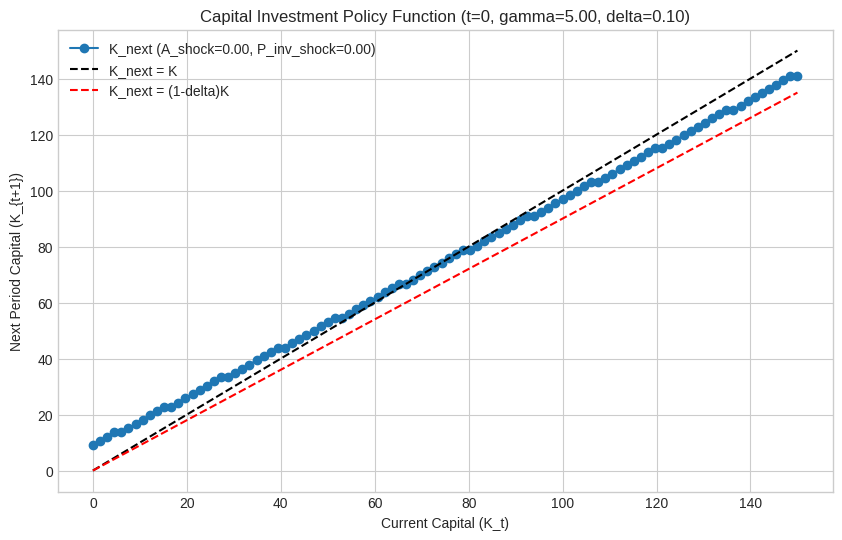

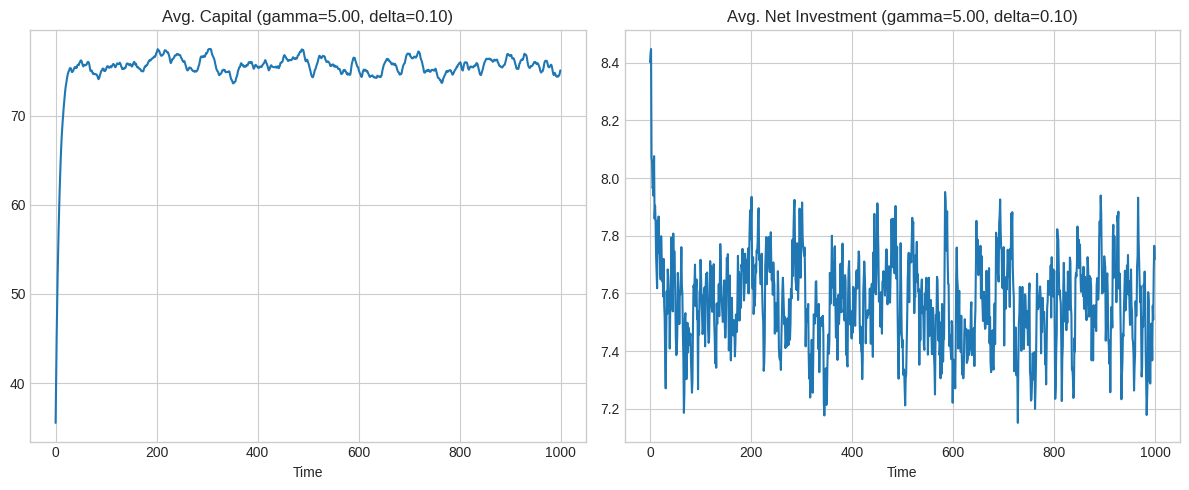


--- Sensitivity Analysis: Scenario 1 (Fixed gamma=5.00, Varying delta) ---
Running for delta = 0.05 (gamma=5.00, sigma_A=0.15)
VFI Solved period t = 45
VFI Solved period t = 30
VFI Solved period t = 15
VFI Solved period t = 0
Running for delta = 0.08 (gamma=5.00, sigma_A=0.15)
VFI Solved period t = 45
VFI Solved period t = 30
VFI Solved period t = 15
VFI Solved period t = 0
Running for delta = 0.12 (gamma=5.00, sigma_A=0.15)
VFI Solved period t = 45
VFI Solved period t = 30
VFI Solved period t = 15
VFI Solved period t = 0
Running for delta = 0.15 (gamma=5.00, sigma_A=0.15)
VFI Solved period t = 45
VFI Solved period t = 30
VFI Solved period t = 15
VFI Solved period t = 0


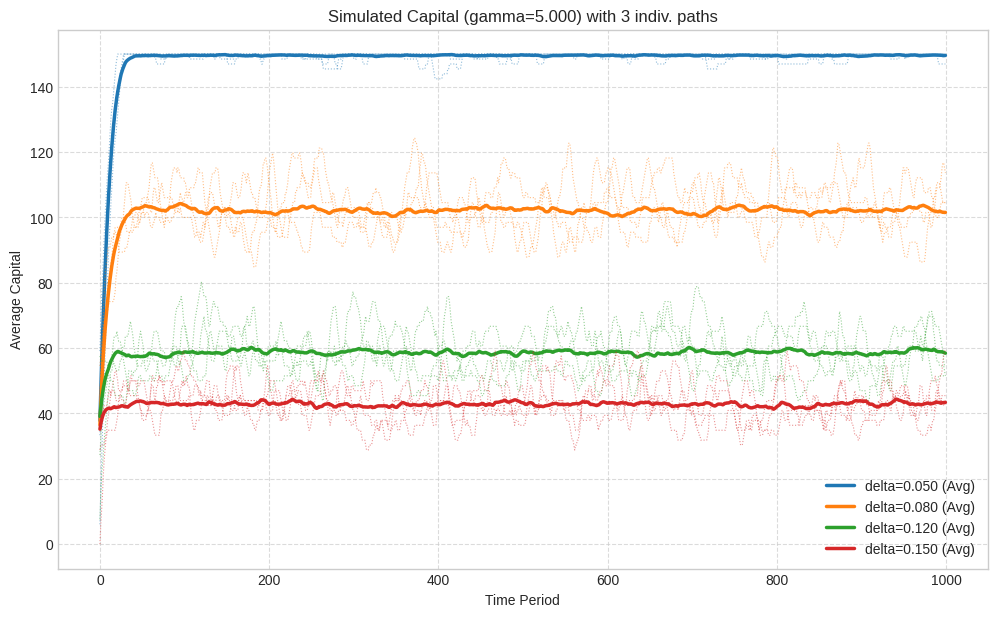

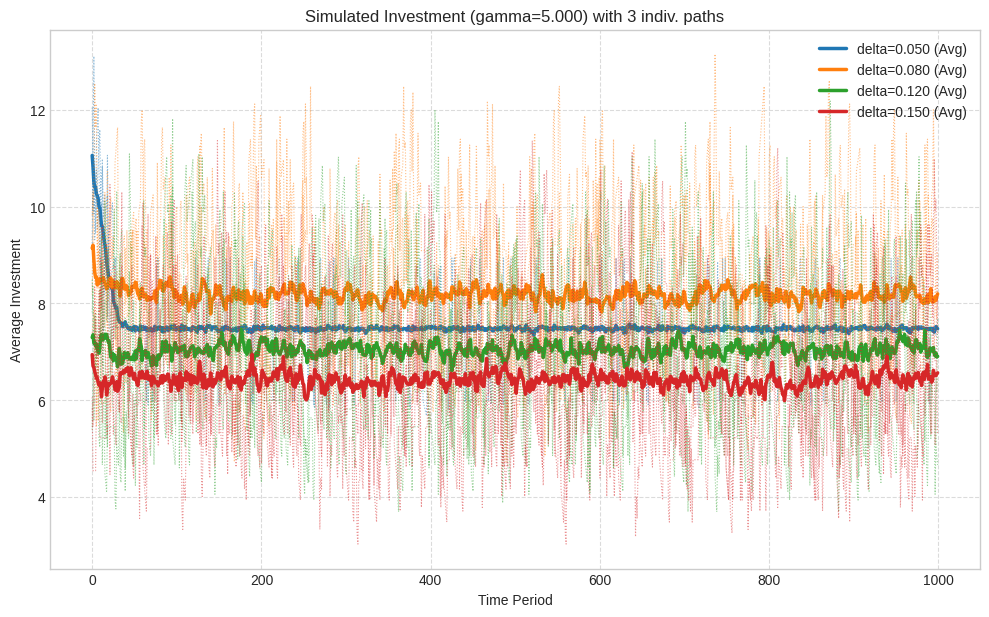

In [8]:
import pandas as pd
import numpy as np
from scipy import stats
from types import SimpleNamespace
import time
from numpy.linalg import matrix_power
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Loading and Preprocessing ---
def clean_currency_value(value_str):
    if pd.isna(value_str) or value_str == '#REF!': return np.nan
    if isinstance(value_str, (int, float)): return float(value_str)
    cleaned = str(value_str).replace('₫', '').replace(',', '').strip()
    if not cleaned: return np.nan
    try: return float(cleaned)
    except ValueError: return np.nan

def load_and_preprocess_data(path):
    try: df = pd.read_csv(path, encoding='utf-8-sig', sep=';')
    except FileNotFoundError: print(f"Error: The file {csv_path} was not found."); return None
    df.columns = df.columns.str.replace('^\ufeff', '', regex=True)
    cols_to_clean = ['Revenue (d2)', 'Variable Cost (n2a, n2e, n2f, n2b)', 'Investment in new capital (n5a, n5b)']
    for col in cols_to_clean:
        if col in df.columns: df[col] = df[col].apply(clean_currency_value)
        else: print(f"Warning: Column {col} not found."); df[col] = np.nan
    labor_col_name_csv = 'Labor (l1)'
    labor_col_name_internal = 'Labor_cleaned'
    if labor_col_name_csv in df.columns:
        df[labor_col_name_internal] = pd.to_numeric(df[labor_col_name_csv], errors='coerce')
    else:
        print(f"Warning: Column '{labor_col_name_csv}' not found in CSV.")
        df[labor_col_name_internal] = np.nan
    df.dropna(subset=['Variable Cost (n2a, n2e, n2f, n2b)', labor_col_name_internal], inplace=True)
    df = df[df[labor_col_name_internal] > 0].copy()
    if df.empty: print("Error: DataFrame empty after initial NaN drop or Labor filter for w_observed."); return None
    scale_factor = 1e9
    df['Variable cost_scaled'] = df['Variable Cost (n2a, n2e, n2f, n2b)'] / scale_factor
    df['Revenue_scaled'] = df['Revenue (d2)'] / scale_factor # Use correct source column
    df['Investment_scaled'] = df['Investment in new capital (n5a, n5b)'] / scale_factor # Use correct source column
    df['w_observed'] = df['Variable cost_scaled'] / df[labor_col_name_internal]

    # Filter out extreme or invalid w values
    df = df[df['w_observed'] > 0].copy() # Use .copy()
    df = df[np.isfinite(df['w_observed'])].copy() # Use .copy()

    if df.empty:
        print("Error: No valid data remaining after preprocessing to calculate 'w'.")
        return None


# --- Tauchen's Method ---
def tauchen(mu, rho, sigma_eps, n_points, m_std_devs):
    uncond_mean=mu/(1.0-rho); uncond_std_dev=sigma_eps/np.sqrt(1.0-rho**2)
    z_max=uncond_mean+m_std_devs*uncond_std_dev; z_min=uncond_mean-m_std_devs*uncond_std_dev
    z_grid=np.linspace(z_min,z_max,n_points); step_size=(z_max-z_min)/(n_points-1)
    P=np.zeros((n_points,n_points))
    for i in range(n_points):
        for j in range(n_points):
            mean_next_z=mu+rho*z_grid[i]
            if j==0: P[i,j]=stats.norm.cdf((z_grid[j]-mean_next_z+step_size/2.0)/sigma_eps)
            elif j==n_points-1: P[i,j]=1.0-stats.norm.cdf((z_grid[j]-mean_next_z-step_size/2.0)/sigma_eps)
            else: P[i,j]=(stats.norm.cdf((z_grid[j]-mean_next_z+step_size/2.0)/sigma_eps)-stats.norm.cdf((z_grid[j]-mean_next_z-step_size/2.0)/sigma_eps))
    return z_grid,P

class FirmModel:
    def __init__(self):
        self.par = SimpleNamespace(); self.sol = SimpleNamespace(); self.sim = SimpleNamespace()

    def setup_parameters(self, data_df, **kwargs):
        par = self.par; par.beta = kwargs.get('beta', 0.96); par.delta = kwargs.get('delta', 0.10)
        par.alpha = kwargs.get('alpha', 0.30); par.nu = kwargs.get('nu', 0.60); par.gamma = kwargs.get('gamma', 10.0) # Reduced gamma
        if data_df is not None and 'w_observed' in data_df and not data_df['w_observed'].empty: par.w = data_df['w_observed'].mean()
        else: par.w = kwargs.get('w', 0.05)
        par.A_base = kwargs.get('A_base', 1.0); par.rho_A = kwargs.get('rho_A', 0.90)
        par.sigma_A = kwargs.get('sigma_A', 0.15) # Increased sigma_A for more volatility
        par.z_n_points = kwargs.get('z_n_points', 5)
        par.P_base = kwargs.get('P_base', 1.0); par.rho_P = kwargs.get('rho_P', 0.80)
        par.sigma_P = kwargs.get('sigma_P', 0.10); par.q_n_points = kwargs.get('q_n_points', 5)
        par.tauchen_m = kwargs.get('tauchen_m', 2); default_k_max = 150.0 # Increased default k_max
        par.k_max_auto_set = False
        if data_df is not None and 'Revenue_scaled' in data_df and par.alpha > 0 and not data_df['Revenue_scaled'].empty:
            median_rev_scaled = data_df['Revenue_scaled'].median()
            if pd.notna(median_rev_scaled) and median_rev_scaled > 0:
                 par.k_max = max(median_rev_scaled * 3.0, default_k_max); par.k_max_auto_set = True # Increased multiplier
            else: par.k_max = default_k_max
        else: par.k_max = default_k_max
        par.k_min = kwargs.get('k_min', 1e-5); par.k_n_points = kwargs.get('k_n_points', 100) # Finer k_grid
        par.k_grid = np.linspace(par.k_min, par.k_max, par.k_n_points)
        par.T_firm = kwargs.get('T_firm', 60) # Longer VFI horizon
        par.z_grid, par.P_z = tauchen(0, par.rho_A, par.sigma_A, par.z_n_points, par.tauchen_m)
        par.q_grid, par.P_q = tauchen(0, par.rho_P, par.sigma_P, par.q_n_points, par.tauchen_m)

    def define_firm_functions(self):
        par=self.par
        def optimal_x(A_val_in,K_val_in,w_val_scalar):
            A_val=np.asarray(A_val_in);K_val=np.asarray(K_val_in);res_shape=np.broadcast(A_val,K_val).shape;x_star_values=np.zeros(res_shape,dtype=float)
            mask_inputs_positive=(K_val>1e-12)&(A_val>1e-12)
            if np.any(mask_inputs_positive):
                K_m=K_val[mask_inputs_positive];A_m=A_val[mask_inputs_positive];K_pow_alpha_m=np.power(K_m,par.alpha);base_m=(par.nu*A_m*K_pow_alpha_m)/w_val_scalar
                temp_base_full_shape=np.full(res_shape,-1.0,dtype=float);temp_base_full_shape[mask_inputs_positive]=base_m
                final_assignment_mask=mask_inputs_positive&(temp_base_full_shape>1e-12)
                if np.any(final_assignment_mask):x_star_values[final_assignment_mask]=np.power(temp_base_full_shape[final_assignment_mask],1.0/(1.0-par.nu))
            if np.isscalar(A_val_in)and np.isscalar(K_val_in):return x_star_values.item()
            return x_star_values
        def variable_profit(A_val_in,K_val_in,w_val_scalar):
            A_val=np.asarray(A_val_in);K_val=np.asarray(K_val_in);profit_values=np.zeros(np.broadcast(A_val,K_val).shape,dtype=float)
            x_s=self.par.optimal_x(A_val,K_val,w_val_scalar);mask_profit_calculable=(K_val>1e-12)&(A_val>1e-12)&(x_s>1e-12)
            if np.any(mask_profit_calculable):
                K_m=K_val[mask_profit_calculable];A_m=A_val[mask_profit_calculable];x_m=x_s[mask_profit_calculable]
                K_pow_alpha_m=np.power(K_m,par.alpha);x_pow_nu_m=np.power(x_m,par.nu);revenue_m=A_m*K_pow_alpha_m*x_pow_nu_m;cost_x_m=w_val_scalar*x_m
                profit_values[mask_profit_calculable]=revenue_m-cost_x_m
            if np.isscalar(A_val_in)and np.isscalar(K_val_in):return profit_values.item()
            return profit_values
        self.par.optimal_x=optimal_x;self.par.variable_profit=variable_profit

    def solve_vfi(self):
        par=self.par;sol=self.sol;sol.V=np.full((par.k_n_points,par.z_n_points,par.q_n_points,par.T_firm),-1e10)
        sol.K_next_policy=np.zeros((par.k_n_points,par.z_n_points,par.q_n_points,par.T_firm));sol.x_policy=np.zeros((par.k_n_points,par.z_n_points,par.q_n_points,par.T_firm))
        A_shocks=par.A_base*np.exp(par.z_grid);P_inv_shocks=par.P_base*np.exp(par.q_grid);t_final=par.T_firm-1
        for k_idx,K_val in enumerate(par.k_grid):
            for z_idx,z_val in enumerate(par.z_grid):
                A_val=A_shocks[z_idx];current_var_profit=par.variable_profit(A_val,K_val,par.w);sol.x_policy[k_idx,z_idx,:,t_final]=par.optimal_x(A_val,K_val,par.w)
                for q_idx,q_val in enumerate(par.q_grid):
                    P_inv_val=P_inv_shocks[q_idx];best_val_for_state=-np.inf;chosen_K_next_for_state=par.k_grid[0]
                    for k_next_idx,K_next_val in enumerate(par.k_grid):
                        net_inv=K_next_val-(1-par.delta)*K_val;adj_c=(par.gamma/2)*(net_inv**2);inv_c=P_inv_val*net_inv;current_total_profit_period=current_var_profit-adj_c-inv_c
                        if current_total_profit_period>best_val_for_state:best_val_for_state=current_total_profit_period;chosen_K_next_for_state=K_next_val
                    sol.V[k_idx,z_idx,q_idx,t_final]=best_val_for_state;sol.K_next_policy[k_idx,z_idx,q_idx,t_final]=chosen_K_next_for_state
        for t_loop in reversed(range(par.T_firm-1)):
            V_next_period=sol.V[:,:,:,t_loop+1];EV_sum_over_q_next=np.tensordot(V_next_period,par.P_q,axes=([2],[1]));EV_next_final=np.tensordot(EV_sum_over_q_next,par.P_z,axes=([1],[1]))
            for k_idx,K_val in enumerate(par.k_grid):
                for z_idx,z_val in enumerate(par.z_grid):
                    A_val=A_shocks[z_idx];current_var_profit=par.variable_profit(A_val,K_val,par.w);sol.x_policy[k_idx,z_idx,:,t_loop]=par.optimal_x(A_val,K_val,par.w)
                    for q_idx,q_val in enumerate(par.q_grid):
                        P_inv_val=P_inv_shocks[q_idx];max_value_for_state=-np.inf;policy_K_next_for_state=par.k_grid[0]
                        for k_next_idx,K_next_val in enumerate(par.k_grid):
                            net_inv=K_next_val-(1.0-par.delta)*K_val;adj_c=(par.gamma/2)*(net_inv**2);inv_c=P_inv_val*net_inv;expected_future_V=EV_next_final[k_next_idx,z_idx,q_idx];current_objective=current_var_profit-adj_c-inv_c+par.beta*expected_future_V
                            if current_objective>max_value_for_state:max_value_for_state=current_objective;policy_K_next_for_state=K_next_val
                        if max_value_for_state == -np.inf : max_value_for_state = -1e9
                        sol.V[k_idx,z_idx,q_idx,t_loop]=max_value_for_state;sol.K_next_policy[k_idx,z_idx,q_idx,t_loop]=policy_K_next_for_state
            if t_loop % (par.T_firm//4 if par.T_firm >=4 else 1) == 0 and par.T_firm > 0 : print(f"VFI Solved period t = {t_loop}")


    def simulate_paths(self, n_firms=500, sim_periods=1000): # Reduced n_firms for faster individual path plotting
        par=self.par; sol=self.sol; sim=self.sim
        sim.K_path=np.zeros((n_firms,sim_periods)); sim.A_path=np.zeros((n_firms,sim_periods))
        sim.P_inv_path=np.zeros((n_firms,sim_periods)); sim.x_path=np.zeros((n_firms,sim_periods))
        sim.I_path=np.zeros((n_firms,sim_periods)); sim.Profit_path=np.zeros((n_firms,sim_periods))

        # Start firms with a wider range of initial capital to see different convergence paths
        initial_k_idx_options = np.linspace(0, par.k_n_points // 2, n_firms, dtype=int, endpoint=False)
        initial_k_idx = np.random.choice(initial_k_idx_options, size=n_firms, replace=True)

        P_z_stat=matrix_power(par.P_z,200)[0,:]; P_q_stat=matrix_power(par.P_q,200)[0,:]
        initial_z_idx=np.random.choice(par.z_n_points,size=n_firms,p=P_z_stat)
        initial_q_idx=np.random.choice(par.q_n_points,size=n_firms,p=P_q_stat)
        curr_k_idx=initial_k_idx.copy(); curr_z_idx=initial_z_idx.copy(); curr_q_idx=initial_q_idx.copy()
        A_shocks=par.A_base*np.exp(par.z_grid); P_inv_shocks=par.P_base*np.exp(par.q_grid)
        for s_t in range(sim_periods):
            pol_t_idx=0
            K_curr_v=par.k_grid[curr_k_idx]; A_curr_v=A_shocks[curr_z_idx]; P_inv_curr_v=P_inv_shocks[curr_q_idx]
            sim.K_path[:,s_t]=K_curr_v; sim.A_path[:,s_t]=A_curr_v; sim.P_inv_path[:,s_t]=P_inv_curr_v
            K_next_ch=np.zeros(n_firms); temp_x_ch=np.zeros(n_firms)
            for i in range(n_firms):
                K_next_ch[i]=sol.K_next_policy[curr_k_idx[i],curr_z_idx[i],curr_q_idx[i],pol_t_idx]
                temp_x_ch[i]=sol.x_policy[curr_k_idx[i],curr_z_idx[i],curr_q_idx[i],pol_t_idx]
            sim.x_path[:,s_t]=temp_x_ch
            net_inv=K_next_ch-(1-par.delta)*K_curr_v; sim.I_path[:,s_t]=net_inv
            var_profs_calc=par.variable_profit(A_curr_v,K_curr_v,par.w)
            adj_cs=(par.gamma/2)*(net_inv**2); inv_cs=P_inv_curr_v*net_inv
            sim.Profit_path[:,s_t]=var_profs_calc-adj_cs-inv_cs
            curr_k_idx=np.array([np.argmin(np.abs(par.k_grid-kn)) for kn in K_next_ch])
            new_z_idx=np.zeros(n_firms,dtype=int); new_q_idx=np.zeros(n_firms,dtype=int)
            for i in range(n_firms):
                new_z_idx[i]=np.random.choice(par.z_n_points,p=par.P_z[curr_z_idx[i],:])
                new_q_idx[i]=np.random.choice(par.q_n_points,p=par.P_q[curr_q_idx[i],:])
            curr_z_idx=new_z_idx; curr_q_idx=new_q_idx

    def plot_baseline_results(self):
        par=self.par; sol=self.sol; sim=self.sim; median_z_idx=par.z_n_points//2 if par.z_n_points >0 else 0; median_q_idx=par.q_n_points//2 if par.q_n_points >0 else 0; pol_t_idx=0
        if par.z_n_points <= 0 or par.q_n_points <=0: print("Cannot plot, z_n or q_n is zero."); return
        print("\n--- Baseline Model Results ---"); plt.figure(figsize=(10,6))
        plt.plot(par.k_grid,sol.K_next_policy[:,median_z_idx,median_q_idx,pol_t_idx],marker='o',label=f'K_next (A_shock={par.z_grid[median_z_idx]:.2f}, P_inv_shock={par.q_grid[median_q_idx]:.2f})')
        plt.plot(par.k_grid,par.k_grid,'k--',label='K_next = K'); plt.plot(par.k_grid,(1-par.delta)*par.k_grid,'r--',label=f'K_next = (1-delta)K')
        plt.xlabel('Current Capital (K_t)'); plt.ylabel('Next Period Capital (K_{t+1})'); plt.title(f'Capital Investment Policy Function (t={pol_t_idx}, gamma={par.gamma:.2f}, delta={par.delta:.2f})')
        plt.legend(); plt.grid(True); plt.show()
        sim_periods=sim.K_path.shape[1]; avg_K=np.mean(sim.K_path,axis=0); avg_I=np.mean(sim.I_path,axis=0); plt.figure(figsize=(12,5))
        plt.subplot(1,2,1); plt.plot(range(sim_periods),avg_K); plt.title(f'Avg. Capital (gamma={par.gamma:.2f}, delta={par.delta:.2f})'); plt.xlabel('Time')
        plt.subplot(1,2,2); plt.plot(range(sim_periods),avg_I); plt.title(f'Avg. Net Investment (gamma={par.gamma:.2f}, delta={par.delta:.2f})'); plt.xlabel('Time')
        plt.tight_layout(); plt.show()

#Helper Plotting Functions for Sensitivity Analysis
def plot_sensitivity_time_series(results_list, fixed_param_name, fixed_param_val, varying_param_name, var_to_plot="Capital", plot_individual_paths=0):
    plt.figure(figsize=(12, 7)) # Increased height for individual paths
    for res_tuple in results_list:
        p_val, sim_K_path, sim_I_path = res_tuple
        path_to_plot = sim_K_path if var_to_plot == "Capital" else sim_I_path
        avg_path = np.mean(path_to_plot, axis=0)
        line, = plt.plot(avg_path, label=f'{varying_param_name}={p_val:.3f} (Avg)', linewidth=2.5) # Thicker line for average

        if plot_individual_paths > 0 and path_to_plot.shape[0] >= plot_individual_paths:
            # Plot a few individual paths for this parameter value
            for i in range(plot_individual_paths):
                plt.plot(path_to_plot[i, :], color=line.get_color(), linestyle=':', alpha=0.5, linewidth=0.8)

    plt.title(f'Simulated {var_to_plot} ({fixed_param_name}={fixed_param_val:.3f})' + (f' with {plot_individual_paths} indiv. paths' if plot_individual_paths>0 else ''))
    plt.xlabel('Time Period') # Removed (1000 periods) as it might vary
    plt.ylabel(f'Average {var_to_plot}')
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

def plot_heatmap_avg_capital(gamma_vals, delta_vals, avg_K_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_K_matrix, annot=True, fmt=".2f", xticklabels=[f"{g:.2f}" for g in gamma_vals], yticklabels=[f"{d:.2f}" for d in delta_vals], cmap="viridis", cbar_kws={'label': 'Average Capital Stock'})
    plt.xlabel('Gamma (Adjustment Cost Parameter $\gamma$)'); plt.ylabel('Delta (Depreciation Rate $\delta$)'); plt.title('Heatmap of Average Simulated Capital'); plt.show()

#Main Execution
if __name__ == '__main__':
    csv_file_path = 'Large Firms.csv' # Using the first CSV for this modified run
    data = load_and_preprocess_data(csv_file_path)
    if data is None: exit()

    print("Running Baseline Model (with parameters to induce more dynamics)")
    baseline_firm = FirmModel()
    # Parameters adjusted for more dynamics:
    # Lower gamma makes adjustment faster.
    # Higher sigma_A (productivity shock std dev) increases volatility.
    baseline_gamma = 5.0  # Lower gamma
    baseline_delta = 0.10
    baseline_sigma_A = 0.15 # Higher productivity shock volatility
    baseline_rho_A = 0.85   # Slightly less persistent productivity shocks
    baseline_k_n_points = 100
    baseline_T_firm = 60


    baseline_firm.setup_parameters(data,
                                   gamma=baseline_gamma,
                                   delta=baseline_delta,
                                   sigma_A=baseline_sigma_A,
                                   rho_A=baseline_rho_A,
                                   k_n_points=baseline_k_n_points,
                                   T_firm=baseline_T_firm)
    baseline_firm.define_firm_functions()
    print(f"Solving VFI for baseline (gamma={baseline_gamma:.2f}, delta={baseline_delta:.2f}, sigma_A={baseline_sigma_A:.2f})...")
    st = time.time(); baseline_firm.solve_vfi(); print(f"VFI took {time.time()-st:.2f}s.")
    print(f"Simulating for baseline (1000 periods)...")
    baseline_firm.simulate_paths(n_firms=100, sim_periods=1000) # n_firms reduced for clarity if plotting individuals later
    baseline_firm.plot_baseline_results() # This plots policy and avg K, I paths

    # Sensitivity Analysis (Example with adjusted parameters for dynamics)
    gamma_scenario1 = baseline_gamma # Use the new baseline gamma
    delta_values_scenario1 = [0.05, 0.08, 0.12, 0.15] # Wider range for delta
    results_scenario1 = []
    print(f"\n--- Sensitivity Analysis: Scenario 1 (Fixed gamma={gamma_scenario1:.2f}, Varying delta) ---")
    for delta_val in delta_values_scenario1:
        print(f"Running for delta = {delta_val:.2f} (gamma={gamma_scenario1:.2f}, sigma_A={baseline_sigma_A:.2f})")
        current_firm = FirmModel()
        current_firm.setup_parameters(data,
                                      gamma=gamma_scenario1,
                                      delta=delta_val,
                                      sigma_A=baseline_sigma_A, # Keep higher sigma_A
                                      rho_A=baseline_rho_A,
                                      k_n_points=baseline_k_n_points,
                                      T_firm=baseline_T_firm)
        current_firm.define_firm_functions()
        st = time.time(); current_firm.solve_vfi(); # print(f"  VFI took {time.time()-st:.2f}s.")
        current_firm.simulate_paths(n_firms=100, sim_periods=1000)
        results_scenario1.append((delta_val, current_firm.sim.K_path, current_firm.sim.I_path))

    plot_sensitivity_time_series(results_scenario1, "gamma", gamma_scenario1, "delta", "Capital", plot_individual_paths=3)
    plot_sensitivity_time_series(results_scenario1, "gamma", gamma_scenario1, "delta", "Investment", plot_individual_paths=3)

In [9]:
import pandas as pd

path2 = "Large Firms.csv"
df=pd.read_csv(path2, sep=';')
df.head(5)

,Revenue (d2),Labor (l1),"Variable Cost (n2a, n2e, n2f, n2b)","Investment in new capital (n5a, n5b)",Raw Materials Cost (n2e)
0,15000000000,50,11000000000,1500000000,7000000000
1,15000000000,6,14600000000,11000000000,13000000000
2,15000000000,5,235000000,0,NaN
3,15000000000,12,630000000,0,NaN
4,15000000000,140,6500000000,2500000000,NaN



Data loaded. Mean observed w: 7770.3195
Mean scaled Raw Material Cost: 2583700.3245

--- Running model for GIVEN gamma and delta ---

Solving VFI for given gamma/delta...
VFI Solved period t = 45
VFI Solved period t = 30
VFI Solved period t = 15
VFI Solved period t = 0
VFI solution took 23.90 seconds.

Plotting Policy Functions for given gamma/delta...


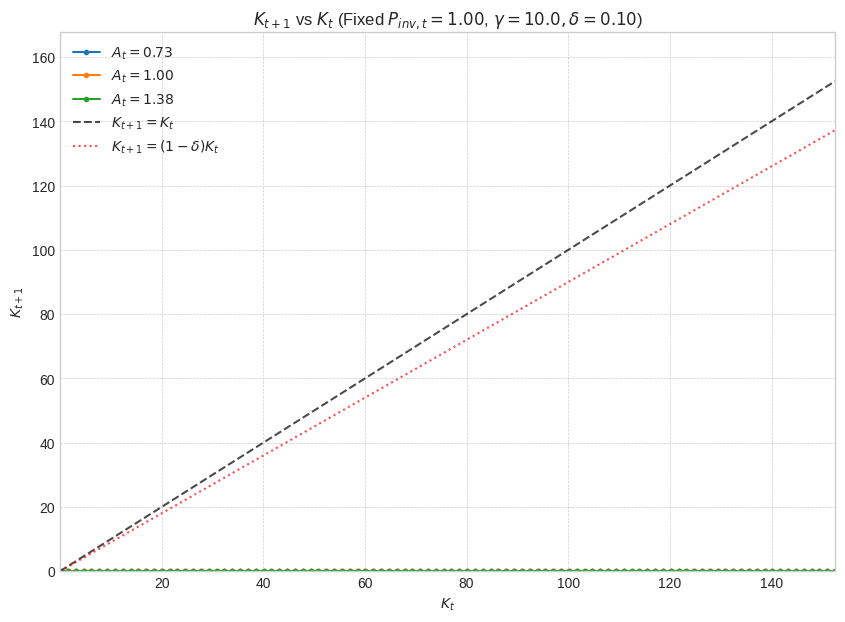

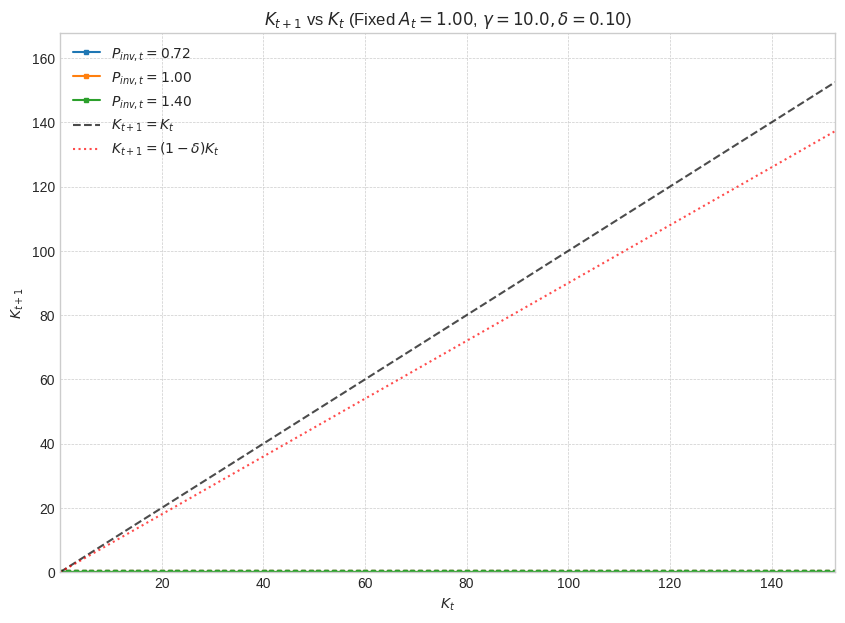

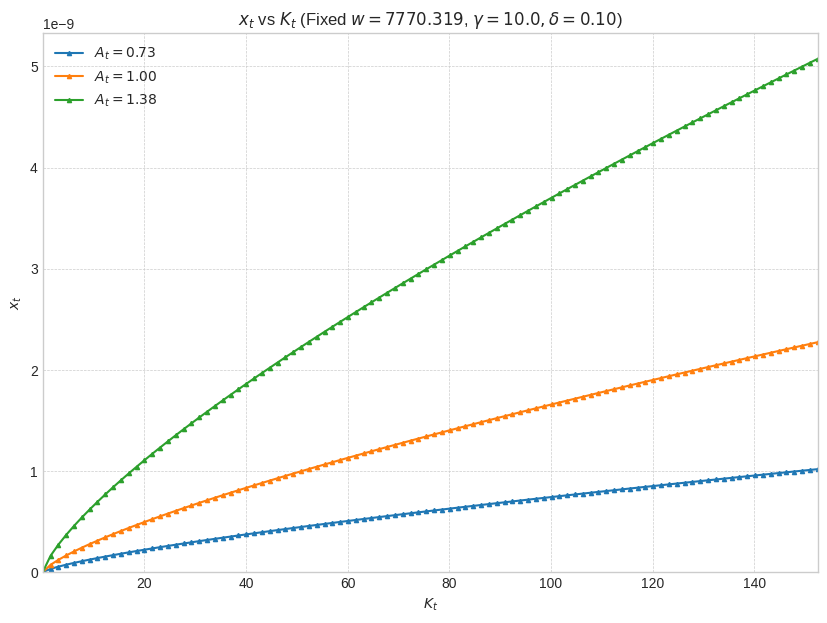


Simulating firm dynamics for given gamma/delta...

Plotting Simulation Results for given gamma/delta...


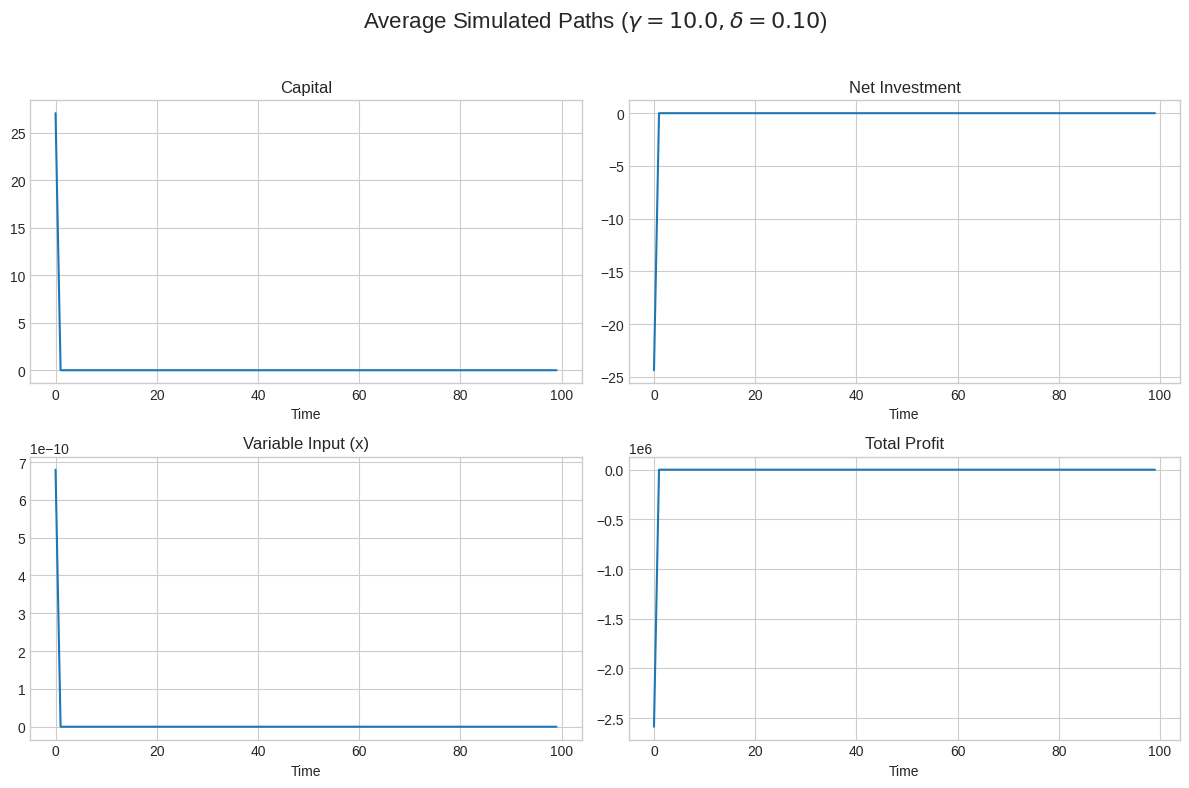


--- Running Sensitivity Analysis for gamma and delta ---
Sensitivity: gamma=5.0, delta=0.05 (1/9)
VFI Solved period t = 28
VFI Solved period t = 21
VFI Solved period t = 14
VFI Solved period t = 7
VFI Solved period t = 0
Sensitivity: gamma=5.0, delta=0.10 (2/9)
VFI Solved period t = 28
VFI Solved period t = 21
VFI Solved period t = 14
VFI Solved period t = 7
VFI Solved period t = 0
Sensitivity: gamma=5.0, delta=0.15 (3/9)
VFI Solved period t = 28
VFI Solved period t = 21
VFI Solved period t = 14
VFI Solved period t = 7
VFI Solved period t = 0
Sensitivity: gamma=15.0, delta=0.05 (4/9)
VFI Solved period t = 28
VFI Solved period t = 21
VFI Solved period t = 14
VFI Solved period t = 7
VFI Solved period t = 0
Sensitivity: gamma=15.0, delta=0.10 (5/9)
VFI Solved period t = 28
VFI Solved period t = 21
VFI Solved period t = 14
VFI Solved period t = 7
VFI Solved period t = 0
Sensitivity: gamma=15.0, delta=0.15 (6/9)
VFI Solved period t = 28
VFI Solved period t = 21
VFI Solved period t = 14
VFI

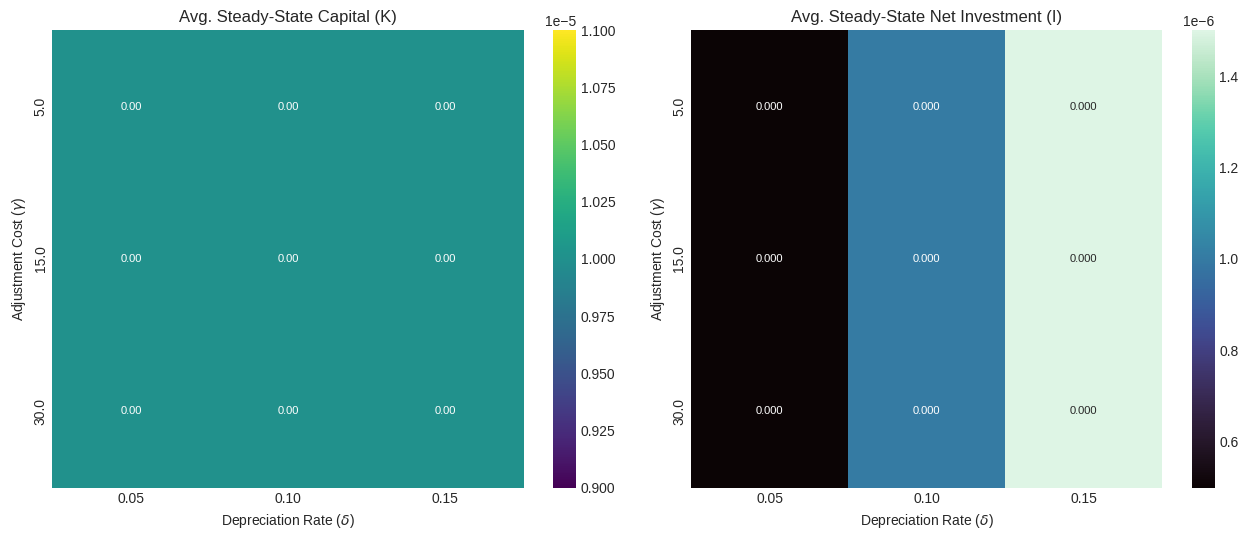

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from types import SimpleNamespace
import time
from numpy.linalg import matrix_power
import matplotlib.pyplot as plt
import seaborn as sns # For heatmaps

# Set a style for better looking plots
plt.style.use('seaborn-v0_8-whitegrid')

# Data Loading and Preprocessing
def clean_currency_value(value_str):
    if pd.isna(value_str) or value_str == '#REF!':
        return np.nan
    if isinstance(value_str, (int, float)): # Already numeric
        return float(value_str)
    cleaned = str(value_str).replace('₫', '').replace(',', '').strip()
    if not cleaned: return np.nan
    try: return float(cleaned)
    except ValueError: return np.nan

def load_and_preprocess_data_new(path2):
    try:
        df = pd.read_csv(path2, encoding='utf-8-sig', sep=';')
    except FileNotFoundError:
        print(f"Error: File {path2} not found.")
        return None
    if df.shape[0] > 0 and df.iloc[0,0] == 0 and df.iloc[0,1] == 'Revenue (d2)':
         pass
    elif df.shape[0] > 0 and df.iloc[0,0] == 0 and pd.isna(df.iloc[0,1]):
        df = df.drop(df.index[0]).reset_index(drop=True)
    df.columns = df.columns.str.replace('^\ufeff', '', regex=True)
    df.columns = [col.strip() for col in df.columns]
    df.rename(columns={"total annual cost of raw materials and intermediate goods used in production": "Raw Materials Cost (n2e)"}, inplace=True)
    cols_to_clean = ['Revenue (d2)', 'Variable Cost (n2a, n2e, n2f, n2b)', 'Investment in new capital (n5a, n5b)', 'Raw Materials Cost (n2e)']
    for col in cols_to_clean:
        if col in df.columns: df[col] = df[col].apply(clean_currency_value)
        else: print(f"Warning: Column '{col}' not found."); df[col] = np.nan
    if 'Labor (l1)' in df.columns: df['Labor (l1)'] = pd.to_numeric(df['Labor (l1)'], errors='coerce')
    else: print("Warning: Column 'Labor (l1)' not found."); df['Labor (l1)'] = np.nan
    df.dropna(subset=['Variable Cost (n2a, n2e, n2f, n2b)', 'Labor (l1)'], how='any', inplace=True)
    df = df[df['Labor (l1)'] > 0]
    if df.empty: print("Error: DataFrame empty after initial NaN drop or Labor filter."); return None
    scale_factor = 1e9
    df['Variable cost_scaled'] = df['Variable Cost (n2a, n2e, n2f, n2b)'] / scale_factor
    df['Revenue_scaled'] = df['Revenue (d2)'] / scale_factor
    df['Investment_scaled'] = df['Investment in new capital (n5a, n5b)'] / scale_factor
    df['RawMaterialCost_scaled'] = df['Raw Materials Cost (n2e)'] / scale_factor
    df['w_observed'] = df['Variable cost_scaled'] / df['Labor (l1)']
    df = df[df['w_observed'] > 0]; df = df[np.isfinite(df['w_observed'])]; df = df[np.isfinite(df['RawMaterialCost_scaled'])]
    if df.empty: print("Error: No valid data remaining after preprocessing and scaling."); return None
    return df

# Tauchen's Method
def tauchen(mu, rho, sigma_eps, n_points, m_std_devs):
    uncond_mean = mu / (1.0 - rho); uncond_std_dev = sigma_eps / np.sqrt(1.0 - rho**2)
    z_max = uncond_mean + m_std_devs * uncond_std_dev; z_min = uncond_mean - m_std_devs * uncond_std_dev
    z_grid = np.linspace(z_min, z_max, n_points); step_size = (z_max - z_min) / (n_points - 1)
    P = np.zeros((n_points, n_points))
    for i in range(n_points):
        for j in range(n_points):
            mean_next_z = mu + rho * z_grid[i]
            if j == 0: P[i, j] = stats.norm.cdf((z_grid[j] - mean_next_z + step_size / 2.0) / sigma_eps)
            elif j == n_points - 1: P[i, j] = 1.0 - stats.norm.cdf((z_grid[j] - mean_next_z - step_size / 2.0) / sigma_eps)
            else: P[i, j] = (stats.norm.cdf((z_grid[j] - mean_next_z + step_size / 2.0) / sigma_eps) -
                           stats.norm.cdf((z_grid[j] - mean_next_z - step_size / 2.0) / sigma_eps))
    return z_grid, P

class FirmModel:
    def __init__(self):
        self.par = SimpleNamespace(); self.sol = SimpleNamespace(); self.sim = SimpleNamespace()

    def setup_parameters(self, data_df, gamma_val, delta_val, **kwargs):
        par = self.par; par.beta = kwargs.get('beta', 0.96); par.delta = delta_val
        par.alpha = kwargs.get('alpha', 0.30); par.nu = kwargs.get('nu', 0.60); par.gamma = gamma_val
        if data_df is not None and 'w_observed' in data_df and not data_df['w_observed'].empty: par.w = data_df['w_observed'].mean()
        else: par.w = kwargs.get('w', 0.05)
        if data_df is not None and 'RawMaterialCost_scaled' in data_df and not data_df['RawMaterialCost_scaled'].empty:
            par.avg_C_M = data_df['RawMaterialCost_scaled'].mean();
            if par.avg_C_M < 0: par.avg_C_M = 0
        else: par.avg_C_M = kwargs.get('avg_C_M', 0.1)
        par.A_base = kwargs.get('A_base', 1.0); par.rho_A = kwargs.get('rho_A', 0.90)
        par.sigma_A = kwargs.get('sigma_A', 0.07); par.z_n_points = kwargs.get('z_n_points', 5)
        par.P_base = kwargs.get('P_base', 1.0); par.rho_P = kwargs.get('rho_P', 0.80)
        par.sigma_P = kwargs.get('sigma_P', 0.10); par.q_n_points = kwargs.get('q_n_points', 5)
        par.tauchen_m = kwargs.get('tauchen_m', 2); default_k_max = 50.0; par.k_max_auto_set = False
        if data_df is not None and 'Revenue_scaled' in data_df and par.alpha > 0 and not data_df['Revenue_scaled'].empty:
            median_rev_scaled = data_df['Revenue_scaled'].median()
            if pd.notna(median_rev_scaled) and median_rev_scaled > 0:
                 par.k_max = max(median_rev_scaled * 2.5, default_k_max); par.k_max_auto_set = True
            else: par.k_max = default_k_max
        else: par.k_max = default_k_max
        par.k_min = kwargs.get('k_min', 1e-5); par.k_n_points = kwargs.get('k_n_points', 50)
        par.k_grid = np.linspace(par.k_min, par.k_max, par.k_n_points)
        par.T_firm = kwargs.get('T_firm', 40)
        par.z_grid, par.P_z = tauchen(0, par.rho_A, par.sigma_A, par.z_n_points, par.tauchen_m)
        par.q_grid, par.P_q = tauchen(0, par.rho_P, par.sigma_P, par.q_n_points, par.tauchen_m)

    def define_firm_functions(self):
        par = self.par
        def optimal_x(A_val_in, K_val_in, w_val_scalar):
            A_val = np.asarray(A_val_in); K_val = np.asarray(K_val_in)
            res_shape = np.broadcast(A_val, K_val).shape; x_star_values = np.zeros(res_shape, dtype=float)
            mask_inputs_positive = (K_val > 1e-12) & (A_val > 1e-12)
            if np.any(mask_inputs_positive):
                K_m = K_val[mask_inputs_positive]; A_m = A_val[mask_inputs_positive]
                K_pow_alpha_m = np.power(K_m, par.alpha)
                base_m = (par.nu * A_m * K_pow_alpha_m) / w_val_scalar
                temp_base_full_shape = np.full(res_shape, -1.0, dtype=float)
                temp_base_full_shape[mask_inputs_positive] = base_m
                final_assignment_mask = mask_inputs_positive & (temp_base_full_shape > 1e-12)
                if np.any(final_assignment_mask):
                     x_star_values[final_assignment_mask] = np.power(temp_base_full_shape[final_assignment_mask], 1.0 / (1.0 - par.nu))
            if np.isscalar(A_val_in) and np.isscalar(K_val_in): return x_star_values.item()
            return x_star_values
        self.par.optimal_x = optimal_x
        def operating_profit(A_val_in, K_val_in, w_val_scalar, avg_C_M_scalar):
            A_val = np.asarray(A_val_in); K_val = np.asarray(K_val_in)
            res_shape = np.broadcast(A_val, K_val).shape
            profit_values = np.full(res_shape, -avg_C_M_scalar if avg_C_M_scalar > 0 else 0.0, dtype=float)
            x_s = self.par.optimal_x(A_val, K_val, w_val_scalar)
            mask_prod_positive = (K_val > 1e-12) & (A_val > 1e-12) & (x_s > 1e-12)
            if np.any(mask_prod_positive):
                K_m = K_val[mask_prod_positive]; A_m = A_val[mask_prod_positive]; x_m = x_s[mask_prod_positive]
                K_pow_alpha_m = np.power(K_m, par.alpha); x_pow_nu_m = np.power(x_m, par.nu)
                revenue_m = A_m * K_pow_alpha_m * x_pow_nu_m; cost_x_m = w_val_scalar * x_m
                profit_values[mask_prod_positive] = revenue_m - cost_x_m - avg_C_M_scalar
            profit_values[~mask_prod_positive] = 0.0
            if np.isscalar(A_val_in) and np.isscalar(K_val_in): return profit_values.item()
            return profit_values
        self.par.operating_profit = operating_profit

    def solve_vfi(self):
        par = self.par; sol = self.sol
        sol.V = np.full((par.k_n_points, par.z_n_points, par.q_n_points, par.T_firm), -1e10)
        sol.K_next_policy = np.zeros((par.k_n_points, par.z_n_points, par.q_n_points, par.T_firm))
        sol.x_policy = np.zeros((par.k_n_points, par.z_n_points, par.q_n_points, par.T_firm))
        A_shocks = par.A_base * np.exp(par.z_grid); P_inv_shocks = par.P_base * np.exp(par.q_grid);
        t_final = par.T_firm - 1 # Renamed to avoid conflict if 't' used elsewhere
        for k_idx, K_val in enumerate(par.k_grid):
            for z_idx, z_val in enumerate(par.z_grid):
                A_val = A_shocks[z_idx]
                current_op_profit = par.operating_profit(A_val, K_val, par.w, par.avg_C_M)
                sol.x_policy[k_idx, z_idx, :, t_final] = par.optimal_x(A_val, K_val, par.w)
                for q_idx, q_val in enumerate(par.q_grid):
                    P_inv_val = P_inv_shocks[q_idx]; best_val_for_state = -np.inf
                    chosen_K_next_for_state = par.k_grid[0]
                    for k_next_idx, K_next_val in enumerate(par.k_grid):
                        net_investment = K_next_val - (1 - par.delta) * K_val
                        adj_cost = (par.gamma / 2.0) * (net_investment**2); inv_cost = P_inv_val * net_investment
                        current_total_profit_period = current_op_profit - adj_cost - inv_cost
                        if current_total_profit_period > best_val_for_state:
                            best_val_for_state = current_total_profit_period; chosen_K_next_for_state = K_next_val
                    sol.V[k_idx, z_idx, q_idx, t_final] = best_val_for_state
                    sol.K_next_policy[k_idx, z_idx, q_idx, t_final] = chosen_K_next_for_state
        for t_loop in reversed(range(par.T_firm - 1)):
            V_next_period = sol.V[:, :, :, t_loop + 1]
            EV_sum_over_q_next = np.tensordot(V_next_period, par.P_q, axes=([2],[1]))
            EV_next_final = np.tensordot(EV_sum_over_q_next, par.P_z, axes=([1],[1]))
            for k_idx, K_val in enumerate(par.k_grid):
                for z_idx, z_val in enumerate(par.z_grid):
                    A_val = A_shocks[z_idx]
                    current_op_profit = par.operating_profit(A_val, K_val, par.w, par.avg_C_M)
                    sol.x_policy[k_idx, z_idx, :, t_loop] = par.optimal_x(A_val, K_val, par.w)
                    for q_idx, q_val in enumerate(par.q_grid):
                        P_inv_val = P_inv_shocks[q_idx]; max_value_for_state = -np.inf # Changed from -1e10 to -np.inf
                        policy_K_next_for_state = par.k_grid[0]
                        for k_next_idx, K_next_val in enumerate(par.k_grid):
                            net_investment = K_next_val - (1.0 - par.delta) * K_val
                            adj_cost = (par.gamma / 2.0) * (net_investment**2); inv_cost = P_inv_val * net_investment
                            expected_future_V = EV_next_final[k_next_idx, z_idx, q_idx]
                            current_objective = current_op_profit - adj_cost - inv_cost + par.beta * expected_future_V
                            if current_objective > max_value_for_state:
                                max_value_for_state = current_objective; policy_K_next_for_state = K_next_val
                        if max_value_for_state == -np.inf : max_value_for_state = -1e9 # if all choices are terrible
                        sol.V[k_idx, z_idx, q_idx, t_loop] = max_value_for_state
                        sol.K_next_policy[k_idx, z_idx, q_idx, t_loop] = policy_K_next_for_state
            if t_loop % (par.T_firm//4 if par.T_firm >=4 else 1) == 0 and par.T_firm > 0 : print(f"VFI Solved period t = {t_loop}")

    def simulate_paths(self, n_firms=1000, sim_periods=60):
        par = self.par; sol = self.sol; sim = self.sim
        sim.K_path = np.zeros((n_firms, sim_periods)); sim.A_path = np.zeros((n_firms, sim_periods))
        sim.P_inv_path = np.zeros((n_firms, sim_periods)); sim.x_path = np.zeros((n_firms, sim_periods))
        sim.I_path = np.zeros((n_firms, sim_periods)); sim.Profit_path = np.zeros((n_firms, sim_periods))
        valid_initial_k_indices = np.where(par.k_grid > 1e-4)[0]
        if len(valid_initial_k_indices) == 0: initial_k_idx = np.zeros(n_firms, dtype=int)
        else:
            upper_idx_bound = len(valid_initial_k_indices) // 3
            if upper_idx_bound == 0 : upper_idx_bound = len(valid_initial_k_indices)
            initial_k_idx = np.random.choice(valid_initial_k_indices[:max(1,upper_idx_bound)], size=n_firms)
        P_z_stat = matrix_power(par.P_z, 200)[0, :]; P_q_stat = matrix_power(par.P_q, 200)[0, :]
        initial_z_idx = np.random.choice(par.z_n_points, size=n_firms, p=P_z_stat)
        initial_q_idx = np.random.choice(par.q_n_points, size=n_firms, p=P_q_stat)
        current_k_idx = initial_k_idx.copy(); current_z_idx = initial_z_idx.copy(); current_q_idx = initial_q_idx.copy()
        A_shocks = par.A_base * np.exp(par.z_grid); P_inv_shocks = par.P_base * np.exp(par.q_grid)
        for s_t in range(sim_periods):
            policy_t_idx = 0
            K_current_vals = par.k_grid[current_k_idx]; A_current_vals = A_shocks[current_z_idx]
            P_inv_current_vals = P_inv_shocks[current_q_idx]
            sim.K_path[:, s_t] = K_current_vals; sim.A_path[:, s_t] = A_current_vals; sim.P_inv_path[:, s_t] = P_inv_current_vals
            K_next_chosen = np.zeros(n_firms); temp_x_chosen = np.zeros(n_firms)
            for i in range(n_firms):
                K_next_chosen[i] = sol.K_next_policy[current_k_idx[i], current_z_idx[i], current_q_idx[i], policy_t_idx]
                temp_x_chosen[i] = sol.x_policy[current_k_idx[i], current_z_idx[i], current_q_idx[i], policy_t_idx]
            sim.x_path[:, s_t] = temp_x_chosen
            net_investment = K_next_chosen - (1 - par.delta) * K_current_vals; sim.I_path[:, s_t] = net_investment
            op_profits_calc = par.operating_profit(A_current_vals, K_current_vals, par.w, par.avg_C_M)
            adj_costs = (par.gamma / 2.0) * (net_investment**2); inv_costs = P_inv_current_vals * net_investment
            sim.Profit_path[:, s_t] = op_profits_calc - adj_costs - inv_costs
            current_k_idx = np.array([np.argmin(np.abs(par.k_grid - kn)) for kn in K_next_chosen])
            new_z_idx = np.zeros(n_firms, dtype=int); new_q_idx = np.zeros(n_firms, dtype=int)
            for i in range(n_firms):
                new_z_idx[i] = np.random.choice(par.z_n_points, p=par.P_z[current_z_idx[i], :])
                new_q_idx[i] = np.random.choice(par.q_n_points, p=par.P_q[current_q_idx[i], :])
            current_z_idx = new_z_idx; current_q_idx = new_q_idx

    def plot_policy_functions(self):
        par = self.par; sol = self.sol
        policy_t_idx = 0 # Use t=0 policy as long-run approximation

        # Ensure par.z_n_points and par.q_n_points are positive before trying to use them for indexing
        if par.z_n_points <= 0 or par.q_n_points <= 0:
            print("Warning: z_n_points or q_n_points is not positive. Cannot plot policy functions.")
            return

        A_shocks_actual = par.A_base * np.exp(par.z_grid)
        P_inv_shocks_actual = par.P_base * np.exp(par.q_grid)

        # K_next vs K_t for different A_t (median P_inv)
        median_q_idx = par.q_n_points // 2
        P_inv_median_val = P_inv_shocks_actual[median_q_idx]

        plt.figure(figsize=(10, 7))
        z_indices_to_plot = sorted(list(set([0, par.z_n_points // 2, par.z_n_points - 1])))
        if par.z_n_points < 3: z_indices_to_plot = [par.z_n_points // 2]

        for z_idx in z_indices_to_plot:
            A_val = A_shocks_actual[z_idx]
            plt.plot(par.k_grid, sol.K_next_policy[:, z_idx, median_q_idx, policy_t_idx],
                     marker='o', markersize=3, linestyle='-',
                     label=f'$A_t = {A_val:.2f}$') # Conceptual A_t

        plt.plot(par.k_grid, par.k_grid, 'k--', alpha=0.7, label='$K_{t+1} = K_t$')
        plt.plot(par.k_grid, (1 - par.delta) * par.k_grid, 'r:', alpha=0.7, label=f'$K_{{t+1}} = (1-\\delta)K_t$')
        plt.xlabel('$K_t$')
        plt.ylabel('$K_{t+1}$')
        # In title, {t+1} is fine as it's text. {inv,t} is also text.
        plt.title(f'$K_{{t+1}}$ vs $K_t$ (Fixed $P_{{inv,t}} = {P_inv_median_val:.2f}$, $\gamma={par.gamma:.1f}, \delta={par.delta:.2f}$)')
        plt.legend(loc='best'); plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.ylim(bottom=max(0, par.k_grid.min() - 0.1 * par.k_max), top = par.k_max * 1.1)
        plt.xlim(left=par.k_grid.min(), right = par.k_max); plt.show()

        # K_next vs K_t for different P_inv,t (median A)
        median_z_idx = par.z_n_points // 2
        A_median_val = A_shocks_actual[median_z_idx]

        plt.figure(figsize=(10, 7))
        q_indices_to_plot = sorted(list(set([0, par.q_n_points // 2, par.q_n_points - 1])))
        if par.q_n_points < 3: q_indices_to_plot = [par.q_n_points//2]

        for q_idx in q_indices_to_plot:
            P_inv_val = P_inv_shocks_actual[q_idx]
            plt.plot(par.k_grid, sol.K_next_policy[:, median_z_idx, q_idx, policy_t_idx],
                     marker='s', markersize=3, linestyle='-',
                     label=f'$P_{{inv,t}} = {P_inv_val:.2f}$') # Conceptual P_inv,t

        plt.plot(par.k_grid, par.k_grid, 'k--', alpha=0.7, label='$K_{t+1} = K_t$')
        plt.plot(par.k_grid, (1 - par.delta) * par.k_grid, 'r:', alpha=0.7, label=f'$K_{{t+1}} = (1-\\delta)K_t$')
        plt.xlabel('$K_t$')
        plt.ylabel('$K_{t+1}$')
        plt.title(f'$K_{{t+1}}$ vs $K_t$ (Fixed $A_t = {A_median_val:.2f}$, $\gamma={par.gamma:.1f}, \delta={par.delta:.2f}$)')
        plt.legend(loc='best'); plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.ylim(bottom=max(0, par.k_grid.min() - 0.1 * par.k_max), top = par.k_max * 1.1)
        plt.xlim(left=par.k_grid.min(), right = par.k_max); plt.show()

        # Variable Input Policy x_t vs K_t
        plt.figure(figsize=(10, 7))
        for z_idx in z_indices_to_plot:
            A_val = A_shocks_actual[z_idx]
            plt.plot(par.k_grid, sol.x_policy[:, z_idx, median_q_idx, policy_t_idx],
                     marker='^', markersize=3, linestyle='-',
                     label=f'$A_t = {A_val:.2f}$') # Conceptual A_t

        plt.xlabel('$K_t$')
        plt.ylabel('$x_t$')
        plt.title(f'$x_t$ vs $K_t$ (Fixed $w = {par.w:.3f}$, $\gamma={par.gamma:.1f}, \delta={par.delta:.2f}$)')
        plt.legend(loc='best'); plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        if np.any(sol.x_policy[:, :, median_q_idx, policy_t_idx] > 1e-9): plt.ylim(bottom=0)
        plt.xlim(left=par.k_grid.min(), right = par.k_max); plt.show()

    def plot_simulation_results(self, gamma_val=None, delta_val=None):
        par = self.par; sim = self.sim; title_suffix = ""; fig_title = "Average Simulated Paths"
        if gamma_val is not None and delta_val is not None:
            title_suffix = f" ($\gamma={gamma_val:.1f}, \delta={delta_val:.2f}$)"; fig_title += title_suffix
        sim_periods = sim.K_path.shape[1]
        if sim_periods == 0: print("No simulation data to plot."); return
        avg_K = np.mean(sim.K_path, axis=0); avg_I = np.mean(sim.I_path, axis=0)
        avg_x = np.mean(sim.x_path, axis=0); avg_Profit = np.mean(sim.Profit_path, axis=0)
        fig, axs = plt.subplots(2,2, figsize=(12, 8)); fig.suptitle(fig_title, fontsize=16)
        axs[0,0].plot(range(sim_periods), avg_K); axs[0,0].set_title('Capital'); axs[0,0].set_xlabel('Time')
        axs[0,1].plot(range(sim_periods), avg_I); axs[0,1].set_title('Net Investment'); axs[0,1].set_xlabel('Time')
        axs[1,0].plot(range(sim_periods), avg_x); axs[1,0].set_title('Variable Input (x)'); axs[1,0].set_xlabel('Time')
        axs[1,1].plot(range(sim_periods), avg_Profit); axs[1,1].set_title('Total Profit'); axs[1,1].set_xlabel('Time')
        plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

    def run_sensitivity_analysis_and_plot_heatmaps(self, data_df_sens, gamma_values, delta_values, base_params):
        print("\n--- Running Sensitivity Analysis for gamma and delta ---")
        avg_K_results = np.zeros((len(gamma_values), len(delta_values)))
        avg_I_results = np.zeros((len(gamma_values), len(delta_values)))
        total_iterations = len(gamma_values) * len(delta_values); current_iter = 0
        for i, gamma_val in enumerate(gamma_values):
            for j, delta_val in enumerate(delta_values):
                current_iter += 1
                print(f"Sensitivity: gamma={gamma_val:.1f}, delta={delta_val:.2f} ({current_iter}/{total_iterations})")
                temp_firm = FirmModel()
                temp_firm.setup_parameters(data_df_sens, gamma_val=gamma_val, delta_val=delta_val, **base_params)
                temp_firm.define_firm_functions(); temp_firm.solve_vfi()
                temp_firm.simulate_paths(n_firms=200, sim_periods=50)
                sim_periods_for_avg = temp_firm.sim.K_path.shape[1] // 2
                if sim_periods_for_avg > 0 :
                    avg_K_results[i, j] = np.mean(temp_firm.sim.K_path[:, -sim_periods_for_avg:])
                    avg_I_results[i, j] = np.mean(temp_firm.sim.I_path[:, -sim_periods_for_avg:])
                else :
                    avg_K_results[i, j] = np.mean(temp_firm.sim.K_path) if temp_firm.sim.K_path.size > 0 else np.nan
                    avg_I_results[i, j] = np.mean(temp_firm.sim.I_path) if temp_firm.sim.I_path.size > 0 else np.nan
        plt.figure(figsize=(13, 5.5))
        plt.subplot(1, 2, 1)
        sns.heatmap(avg_K_results, annot=True, fmt=".2f", cmap="viridis", xticklabels=[f"{d:.2f}" for d in delta_values], yticklabels=[f"{g:.1f}" for g in gamma_values], annot_kws={"size": 8})
        plt.xlabel("Depreciation Rate ($\delta$)"); plt.ylabel("Adjustment Cost ($\gamma$)"); plt.title("Avg. Steady-State Capital (K)")
        plt.subplot(1, 2, 2)
        sns.heatmap(avg_I_results, annot=True, fmt=".3f", cmap="mako", xticklabels=[f"{d:.2f}" for d in delta_values], yticklabels=[f"{g:.1f}" for g in gamma_values], annot_kws={"size": 8})
        plt.xlabel("Depreciation Rate ($\delta$)"); plt.ylabel("Adjustment Cost ($\gamma$)"); plt.title("Avg. Steady-State Net Investment (I)")
        plt.tight_layout(); plt.show()
        return avg_K_results, avg_I_results

#Main Execution
if __name__ == '__main__':
    csv_file_path = 'Large Firms.csv'
    data = load_and_preprocess_data_new(csv_file_path)
    if data is None: print("Failed to load or process data. Exiting.")
    else:
        print(f"\nData loaded. Mean observed w: {data['w_observed'].mean() if not data['w_observed'].empty else 'N/A':.4f}")
        print(f"Mean scaled Raw Material Cost: {data['RawMaterialCost_scaled'].mean() if 'RawMaterialCost_scaled' in data and not data['RawMaterialCost_scaled'].empty else 'N/A':.4f}")
        print("\n--- Running model for GIVEN gamma and delta ---")
        gamma_given = 10.0; delta_given = 0.10
        base_sim_params = {'beta': 0.96, 'alpha': 0.30, 'nu': 0.60, 'A_base': 1.0, 'rho_A': 0.9, 'sigma_A': 0.07, 'z_n_points': 5, 'P_base': 1.0, 'rho_P': 0.8, 'sigma_P': 0.1, 'q_n_points': 5, 'tauchen_m': 2, 'k_n_points': 100, 'T_firm': 60 }
        firm_single_run = FirmModel()
        firm_single_run.setup_parameters(data, gamma_val=gamma_given, delta_val=delta_given, **base_sim_params)
        firm_single_run.define_firm_functions()
        print("\nSolving VFI for given gamma/delta..."); start_time = time.time(); firm_single_run.solve_vfi(); end_time = time.time()
        print(f"VFI solution took {end_time - start_time:.2f} seconds.")
        print("\nPlotting Policy Functions for given gamma/delta..."); firm_single_run.plot_policy_functions()
        print("\nSimulating firm dynamics for given gamma/delta..."); firm_single_run.simulate_paths(n_firms=500, sim_periods=100)
        print("\nPlotting Simulation Results for given gamma/delta..."); firm_single_run.plot_simulation_results(gamma_val=gamma_given, delta_val=delta_given)

        gamma_values_sens = [5.0, 15.0, 30.0]; delta_values_sens = [0.05, 0.10, 0.15]
        base_sensitivity_params = {'beta': 0.96, 'alpha': 0.30, 'nu': 0.60,'A_base': 1.0, 'rho_A': 0.9, 'sigma_A': 0.07, 'z_n_points': 3, 'P_base': 1.0, 'rho_P': 0.8, 'sigma_P': 0.1, 'q_n_points': 3, 'tauchen_m': 2, 'k_n_points': 30, 'T_firm': 30 }
        heatmap_runner_firm = FirmModel()
        K_heatmap_data, I_heatmap_data = heatmap_runner_firm.run_sensitivity_analysis_and_plot_heatmaps(data_df_sens=data, gamma_values=gamma_values_sens, delta_values=delta_values_sens, base_params=base_sensitivity_params)

This output makes no sense, there must have been something wrong as seen in the next part of code too.

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from types import SimpleNamespace
import time
from numpy.linalg import matrix_power
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')

#Data Loading and Preprocessing
def clean_currency_value(value_str):
    if pd.isna(value_str) or value_str == '#REF!': return np.nan
    if isinstance(value_str, (int, float)): return float(value_str)
    cleaned = str(value_str).replace(',', '').strip()
    if not cleaned: return np.nan
    try: return float(cleaned)
    except ValueError: return np.nan

def load_and_preprocess_data_new(path2):
    try: df = pd.read_csv(path2, encoding='utf-8-sig', sep=';')
    except FileNotFoundError: print(f"Error: File {csv_path} not found."); return None
    if df.shape[0] > 0 and df.iloc[0,0] == 0 and df.iloc[0,1] == 'Revenue (d2)': pass
    elif df.shape[0] > 0 and df.iloc[0,0] == 0 and pd.isna(df.iloc[0,1]): df = df.drop(df.index[0]).reset_index(drop=True)
    df.columns = df.columns.str.replace('^\ufeff', '', regex=True)
    df.columns = [col.strip() for col in df.columns]
    df.rename(columns={"total annual cost of raw materials and intermediate goods used in production": "Raw Materials Cost (n2e)"}, inplace=True)
    cols_to_clean = ['Revenue (d2)', 'Variable Cost (n2a, n2e, n2f, n2b)', 'Investment in new capital (n5a, n5b)', 'Raw Materials Cost (n2e)']
    for col in cols_to_clean:
        if col in df.columns: df[col] = df[col].apply(clean_currency_value)
        else: print(f"Warning: Column '{col}' not found."); df[col] = np.nan
    if 'Labor (l1)' in df.columns: df['Labor (l1)'] = pd.to_numeric(df['Labor (l1)'], errors='coerce')
    else: print("Warning: Column 'Labor (l1)' not found."); df['Labor (l1)'] = np.nan
    df.dropna(subset=['Variable Cost (n2a, n2e, n2f, n2b)', 'Labor (l1)', 'Raw Materials Cost (n2e)'], how='any', inplace=True) # Ensure RawMaterialCost is present for avg_C_M
    df = df[df['Labor (l1)'] > 0]
    if df.empty: print("Error: DataFrame empty after initial NaN drop or Labor filter."); return None
    scale_factor = 1e9
    df['Variable cost_scaled'] = df['Variable Cost (n2a, n2e, n2f, n2b)'] / scale_factor
    df['Revenue_scaled'] = df['Revenue (d2)'] / scale_factor
    df['Investment_scaled'] = df['Investment in new capital (n5a, n5b)'] / scale_factor
    df['RawMaterialCost_scaled'] = df['Raw Materials Cost (n2e)'] / scale_factor
    df['w_observed'] = df['Variable cost_scaled'] / df['Labor (l1)']
    df = df[df['w_observed'] > 0]; df = df[np.isfinite(df['w_observed'])]; df = df[np.isfinite(df['RawMaterialCost_scaled'])]
    if df.empty: print("Error: No valid data remaining after preprocessing and scaling."); return None
    return df

#Tauchen's Method
def tauchen(mu, rho, sigma_eps, n_points, m_std_devs):
    uncond_mean = mu / (1.0 - rho); uncond_std_dev = sigma_eps / np.sqrt(1.0 - rho**2)
    z_max = uncond_mean + m_std_devs * uncond_std_dev; z_min = uncond_mean - m_std_devs * uncond_std_dev
    z_grid = np.linspace(z_min, z_max, n_points); step_size = (z_max - z_min) / (n_points - 1)
    P = np.zeros((n_points, n_points))
    for i in range(n_points):
        for j in range(n_points):
            mean_next_z = mu + rho * z_grid[i]
            if j == 0: P[i, j] = stats.norm.cdf((z_grid[j] - mean_next_z + step_size / 2.0) / sigma_eps)
            elif j == n_points - 1: P[i, j] = 1.0 - stats.norm.cdf((z_grid[j] - mean_next_z - step_size / 2.0) / sigma_eps)
            else: P[i, j] = (stats.norm.cdf((z_grid[j] - mean_next_z + step_size / 2.0) / sigma_eps) -
                           stats.norm.cdf((z_grid[j] - mean_next_z - step_size / 2.0) / sigma_eps))
    return z_grid, P

class FirmModel:
    def __init__(self):
        self.par = SimpleNamespace(); self.sol = SimpleNamespace(); self.sim = SimpleNamespace()

    def setup_parameters(self, data_df, gamma_val, delta_val, **kwargs):
        par = self.par; par.beta = kwargs.get('beta', 0.96); par.delta = delta_val
        par.alpha = kwargs.get('alpha', 0.30); par.nu = kwargs.get('nu', 0.60); par.gamma = gamma_val
        if data_df is not None and 'w_observed' in data_df and not data_df['w_observed'].empty: par.w = data_df['w_observed'].mean()
        else: par.w = kwargs.get('w', 0.05)

        # Allow avg_C_M to be passed via kwargs for sensitivity, otherwise calculate from data
        if 'avg_C_M' in kwargs:
            par.avg_C_M = kwargs.get('avg_C_M')
        elif data_df is not None and 'RawMaterialCost_scaled' in data_df and not data_df['RawMaterialCost_scaled'].empty:
            par.avg_C_M = data_df['RawMaterialCost_scaled'].mean();
            if par.avg_C_M < 0: par.avg_C_M = 0
        else: par.avg_C_M = 0.1 # Fallback if no data and not in kwargs

        par.A_base = kwargs.get('A_base', 1.0); par.rho_A = kwargs.get('rho_A', 0.90)
        par.sigma_A = kwargs.get('sigma_A', 0.07); par.z_n_points = kwargs.get('z_n_points', 5)
        par.P_base = kwargs.get('P_base', 1.0); par.rho_P = kwargs.get('rho_P', 0.80)
        par.sigma_P = kwargs.get('sigma_P', 0.10); par.q_n_points = kwargs.get('q_n_points', 5)
        par.tauchen_m = kwargs.get('tauchen_m', 2); default_k_max = 50.0; par.k_max_auto_set = False
        if data_df is not None and 'Revenue_scaled' in data_df and par.alpha > 0 and not data_df['Revenue_scaled'].empty:
            median_rev_scaled = data_df['Revenue_scaled'].median()
            if pd.notna(median_rev_scaled) and median_rev_scaled > 0:
                 par.k_max = max(median_rev_scaled * 2.5, default_k_max); par.k_max_auto_set = True
            else: par.k_max = default_k_max
        else: par.k_max = default_k_max
        par.k_min = kwargs.get('k_min', 1e-5); par.k_n_points = kwargs.get('k_n_points', 50)
        par.k_grid = np.linspace(par.k_min, par.k_max, par.k_n_points)
        par.T_firm = kwargs.get('T_firm', 40)
        par.z_grid, par.P_z = tauchen(0, par.rho_A, par.sigma_A, par.z_n_points, par.tauchen_m)
        par.q_grid, par.P_q = tauchen(0, par.rho_P, par.sigma_P, par.q_n_points, par.tauchen_m)

    def define_firm_functions(self): # Modified from previous to store revenue_function
        par = self.par
        def optimal_x(A_val_in, K_val_in, w_val_scalar):
            A_val = np.asarray(A_val_in); K_val = np.asarray(K_val_in)
            res_shape = np.broadcast(A_val, K_val).shape; x_star_values = np.zeros(res_shape, dtype=float)
            mask_inputs_positive = (K_val > 1e-12) & (A_val > 1e-12)
            if np.any(mask_inputs_positive):
                K_m = K_val[mask_inputs_positive]; A_m = A_val[mask_inputs_positive]
                K_pow_alpha_m = np.power(K_m, par.alpha)
                base_m = (par.nu * A_m * K_pow_alpha_m) / w_val_scalar
                temp_base_full_shape = np.full(res_shape, -1.0, dtype=float)
                temp_base_full_shape[mask_inputs_positive] = base_m
                final_assignment_mask = mask_inputs_positive & (temp_base_full_shape > 1e-12)
                if np.any(final_assignment_mask):
                     x_star_values[final_assignment_mask] = np.power(temp_base_full_shape[final_assignment_mask], 1.0 / (1.0 - par.nu))
            if np.isscalar(A_val_in) and np.isscalar(K_val_in): return x_star_values.item()
            return x_star_values
        self.par.optimal_x = optimal_x

        def revenue_function(A_val_in, K_val_in, x_val_in): # For calculating output/revenue
            A_val = np.asarray(A_val_in); K_val = np.asarray(K_val_in); x_val = np.asarray(x_val_in)
            res_shape = np.broadcast(A_val, K_val, x_val).shape; revenue_values = np.zeros(res_shape, dtype=float)
            mask_prod_positive = (K_val > 1e-12) & (A_val > 1e-12) & (x_val > 1e-12)
            if np.any(mask_prod_positive):
                K_m = K_val[mask_prod_positive]; A_m = A_val[mask_prod_positive]; x_m = x_val[mask_prod_positive]
                K_pow_alpha_m = np.power(K_m, par.alpha); x_pow_nu_m = np.power(x_m, par.nu)
                revenue_values[mask_prod_positive] = A_m * K_pow_alpha_m * x_pow_nu_m
            if np.isscalar(A_val_in) and np.isscalar(K_val_in) and np.isscalar(x_val_in): return revenue_values.item()
            return revenue_values
        self.par.revenue_function = revenue_function # Store for use in simulation

        def operating_profit(A_val_in, K_val_in, w_val_scalar, avg_C_M_scalar):
            A_val = np.asarray(A_val_in); K_val = np.asarray(K_val_in)
            x_s = self.par.optimal_x(A_val, K_val, w_val_scalar)
            R_val = self.par.revenue_function(A_val, K_val, x_s) # Use stored revenue_function
            cost_x_val = w_val_scalar * x_s
            profit_values = R_val - cost_x_val - avg_C_M_scalar
            mask_no_production = (R_val <= 1e-12)
            if np.isscalar(profit_values):
                if mask_no_production: profit_values = 0.0
            else: profit_values[mask_no_production] = 0.0
            if np.isscalar(A_val_in) and np.isscalar(K_val_in): return profit_values.item()
            return profit_values
        self.par.operating_profit = operating_profit

    def solve_vfi(self):
        par = self.par; sol = self.sol; sol.V = np.full((par.k_n_points, par.z_n_points, par.q_n_points, par.T_firm), -1e10)
        sol.K_next_policy = np.zeros((par.k_n_points, par.z_n_points, par.q_n_points, par.T_firm)); sol.x_policy = np.zeros((par.k_n_points, par.z_n_points, par.q_n_points, par.T_firm))
        A_shocks = par.A_base * np.exp(par.z_grid); P_inv_shocks = par.P_base * np.exp(par.q_grid); t_final = par.T_firm - 1
        for k_idx, K_val in enumerate(par.k_grid):
            for z_idx, z_val in enumerate(par.z_grid):
                A_val = A_shocks[z_idx]; current_op_profit = par.operating_profit(A_val, K_val, par.w, par.avg_C_M)
                sol.x_policy[k_idx, z_idx, :, t_final] = par.optimal_x(A_val, K_val, par.w)
                for q_idx, q_val in enumerate(par.q_grid):
                    P_inv_val = P_inv_shocks[q_idx]; best_val_for_state = -np.inf; chosen_K_next_for_state = par.k_grid[0]
                    for k_next_idx, K_next_val in enumerate(par.k_grid):
                        net_investment = K_next_val - (1 - par.delta) * K_val; adj_cost = (par.gamma / 2.0) * (net_investment**2); inv_cost = P_inv_val * net_investment
                        current_total_profit_period = current_op_profit - adj_cost - inv_cost
                        if current_total_profit_period > best_val_for_state: best_val_for_state = current_total_profit_period; chosen_K_next_for_state = K_next_val
                    sol.V[k_idx, z_idx, q_idx, t_final] = best_val_for_state; sol.K_next_policy[k_idx, z_idx, q_idx, t_final] = chosen_K_next_for_state
        for t_loop in reversed(range(par.T_firm - 1)):
            V_next_period = sol.V[:, :, :, t_loop + 1]; EV_sum_over_q_next = np.tensordot(V_next_period, par.P_q, axes=([2],[1])); EV_next_final = np.tensordot(EV_sum_over_q_next, par.P_z, axes=([1],[1]))
            for k_idx, K_val in enumerate(par.k_grid):
                for z_idx, z_val in enumerate(par.z_grid):
                    A_val = A_shocks[z_idx]; current_op_profit = par.operating_profit(A_val, K_val, par.w, par.avg_C_M)
                    sol.x_policy[k_idx, z_idx, :, t_loop] = par.optimal_x(A_val, K_val, par.w)
                    for q_idx, q_val in enumerate(par.q_grid):
                        P_inv_val = P_inv_shocks[q_idx]; max_value_for_state = -np.inf; policy_K_next_for_state = par.k_grid[0]
                        for k_next_idx, K_next_val in enumerate(par.k_grid):
                            net_investment = K_next_val - (1.0 - par.delta) * K_val; adj_cost = (par.gamma / 2.0) * (net_investment**2); inv_cost = P_inv_val * net_investment
                            expected_future_V = EV_next_final[k_next_idx, z_idx, q_idx]; current_objective = current_op_profit - adj_cost - inv_cost + par.beta * expected_future_V
                            if current_objective > max_value_for_state: max_value_for_state = current_objective; policy_K_next_for_state = K_next_val
                        if max_value_for_state == -np.inf : max_value_for_state = -1e9
                        sol.V[k_idx, z_idx, q_idx, t_loop] = max_value_for_state; sol.K_next_policy[k_idx, z_idx, q_idx, t_loop] = policy_K_next_for_state
            if t_loop % (par.T_firm//4 if par.T_firm >=4 else 1) == 0 and par.T_firm > 0: print(f"VFI Solved period t = {t_loop}")

    def simulate_paths(self, n_firms=1000, sim_periods=60): # MODIFIED to store Revenue_path
        par = self.par; sol = self.sol; sim = self.sim
        sim.K_path = np.zeros((n_firms, sim_periods)); sim.A_path = np.zeros((n_firms, sim_periods))
        sim.P_inv_path = np.zeros((n_firms, sim_periods)); sim.x_path = np.zeros((n_firms, sim_periods))
        sim.I_path = np.zeros((n_firms, sim_periods)); sim.Profit_path = np.zeros((n_firms, sim_periods))
        sim.Revenue_path = np.zeros((n_firms, sim_periods)) # <-- ADDED for output
        valid_initial_k_indices = np.where(par.k_grid > 1e-4)[0]
        if len(valid_initial_k_indices) == 0: initial_k_idx = np.zeros(n_firms, dtype=int)
        else: upper_idx_bound = len(valid_initial_k_indices) // 3; initial_k_idx = np.random.choice(valid_initial_k_indices[:max(1,upper_idx_bound)], size=n_firms)
        P_z_stat = matrix_power(par.P_z, 200)[0, :]; P_q_stat = matrix_power(par.P_q, 200)[0, :]
        initial_z_idx = np.random.choice(par.z_n_points, size=n_firms, p=P_z_stat); initial_q_idx = np.random.choice(par.q_n_points, size=n_firms, p=P_q_stat)
        current_k_idx = initial_k_idx.copy(); current_z_idx = initial_z_idx.copy(); current_q_idx = initial_q_idx.copy()
        A_shocks = par.A_base * np.exp(par.z_grid); P_inv_shocks = par.P_base * np.exp(par.q_grid)
        for s_t in range(sim_periods):
            policy_t_idx = 0; K_current_vals = par.k_grid[current_k_idx]; A_current_vals = A_shocks[current_z_idx]; P_inv_current_vals = P_inv_shocks[current_q_idx]
            sim.K_path[:, s_t] = K_current_vals; sim.A_path[:, s_t] = A_current_vals; sim.P_inv_path[:, s_t] = P_inv_current_vals
            K_next_chosen = np.zeros(n_firms); temp_x_chosen = np.zeros(n_firms)
            for i in range(n_firms): # Policy lookup
                K_next_chosen[i] = sol.K_next_policy[current_k_idx[i], current_z_idx[i], current_q_idx[i], policy_t_idx]
                temp_x_chosen[i] = sol.x_policy[current_k_idx[i], current_z_idx[i], current_q_idx[i], policy_t_idx]
            sim.x_path[:, s_t] = temp_x_chosen
            sim.Revenue_path[:, s_t] = par.revenue_function(A_current_vals, K_current_vals, temp_x_chosen) # Store revenue
            net_investment = K_next_chosen - (1 - par.delta) * K_current_vals; sim.I_path[:, s_t] = net_investment
            op_profits_calc = par.operating_profit(A_current_vals, K_current_vals, par.w, par.avg_C_M)
            adj_costs = (par.gamma / 2.0) * (net_investment**2); inv_costs = P_inv_current_vals * net_investment
            sim.Profit_path[:, s_t] = op_profits_calc - adj_costs - inv_costs
            current_k_idx = np.array([np.argmin(np.abs(par.k_grid - kn)) for kn in K_next_chosen])
            new_z_idx = np.zeros(n_firms, dtype=int); new_q_idx = np.zeros(n_firms, dtype=int)
            for i in range(n_firms):
                new_z_idx[i] = np.random.choice(par.z_n_points, p=par.P_z[current_z_idx[i], :]); new_q_idx[i] = np.random.choice(par.q_n_points, p=par.P_q[current_q_idx[i], :])
            current_z_idx = new_z_idx; current_q_idx = new_q_idx

    def plot_policy_functions(self):
        par = self.par; sol = self.sol; policy_t_idx = 0
        if par.z_n_points <= 0 or par.q_n_points <= 0: print("Warning: z_n or q_n is not positive."); return
        A_shocks_actual = par.A_base * np.exp(par.z_grid); P_inv_shocks_actual = par.P_base * np.exp(par.q_grid)
        median_q_idx = par.q_n_points // 2; P_inv_median_val = P_inv_shocks_actual[median_q_idx]
        plt.figure(figsize=(10, 7)); z_indices_to_plot = sorted(list(set([0, par.z_n_points // 2, par.z_n_points - 1]))) if par.z_n_points >0 else []
        if par.z_n_points < 3 and par.z_n_points > 0: z_indices_to_plot = [par.z_n_points // 2]
        for z_idx in z_indices_to_plot: A_val = A_shocks_actual[z_idx]; plt.plot(par.k_grid, sol.K_next_policy[:, z_idx, median_q_idx, policy_t_idx], marker='o', markersize=3, linestyle='-', label=f'$A_t = {A_val:.2f}$')
        plt.plot(par.k_grid, par.k_grid, 'k--', alpha=0.7, label='$K_{t+1} = K_t$'); plt.plot(par.k_grid, (1 - par.delta) * par.k_grid, 'r:', alpha=0.7, label=f'$K_{{t+1}} = (1-\\delta)K_t$')
        plt.xlabel('$K_t$'); plt.ylabel('$K_{t+1}$'); plt.title(f'$K_{{t+1}}$ vs $K_t$ (Fixed $P_{{inv,t}} = {P_inv_median_val:.2f}$, $\gamma={par.gamma:.1f}, \delta={par.delta:.2f}$)')
        plt.legend(loc='best'); plt.grid(True, which='both', linestyle='--', linewidth=0.5); plt.ylim(bottom=max(0, par.k_grid.min() - 0.1 * par.k_max), top = par.k_max * 1.1); plt.xlim(left=par.k_grid.min(), right = par.k_max); plt.show()
        median_z_idx = par.z_n_points // 2 if par.z_n_points > 0 else 0; A_median_val = A_shocks_actual[median_z_idx] if par.z_n_points > 0 else par.A_base
        plt.figure(figsize=(10, 7)); q_indices_to_plot = sorted(list(set([0, par.q_n_points // 2, par.q_n_points - 1]))) if par.q_n_points >0 else []
        if par.q_n_points < 3 and par.q_n_points >0 : q_indices_to_plot = [par.q_n_points//2]
        for q_idx in q_indices_to_plot: P_inv_val = P_inv_shocks_actual[q_idx]; plt.plot(par.k_grid, sol.K_next_policy[:, median_z_idx, q_idx, policy_t_idx], marker='s', markersize=3, linestyle='-', label=f'$P_{{inv,t}} = {P_inv_val:.2f}$')
        plt.plot(par.k_grid, par.k_grid, 'k--', alpha=0.7, label='$K_{t+1} = K_t$'); plt.plot(par.k_grid, (1 - par.delta) * par.k_grid, 'r:', alpha=0.7, label=f'$K_{{t+1}} = (1-\\delta)K_t$')
        plt.xlabel('$K_t$'); plt.ylabel('$K_{t+1}$'); plt.title(f'$K_{{t+1}}$ vs $K_t$ (Fixed $A_t = {A_median_val:.2f}$, $\gamma={par.gamma:.1f}, \delta={par.delta:.2f}$)')
        plt.legend(loc='best'); plt.grid(True, which='both', linestyle='--', linewidth=0.5); plt.ylim(bottom=max(0, par.k_grid.min() - 0.1 * par.k_max), top = par.k_max * 1.1); plt.xlim(left=par.k_grid.min(), right = par.k_max); plt.show()
        plt.figure(figsize=(10, 7))
        for z_idx in z_indices_to_plot: A_val = A_shocks_actual[z_idx]; plt.plot(par.k_grid, sol.x_policy[:, z_idx, median_q_idx, policy_t_idx], marker='^', markersize=3, linestyle='-', label=f'$A_t = {A_val:.2f}$')
        plt.xlabel('$K_t$'); plt.ylabel('$x_t$'); plt.title(f'$x_t$ vs $K_t$ (Fixed $w = {par.w:.3f}$, $\gamma={par.gamma:.1f}, \delta={par.delta:.2f}$)')
        plt.legend(loc='best'); plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        if hasattr(sol, 'x_policy') and np.any(sol.x_policy[:, :, median_q_idx, policy_t_idx] > 1e-9): plt.ylim(bottom=0)
        plt.xlim(left=par.k_grid.min(), right = par.k_max); plt.show()

    def plot_simulation_results(self, gamma_val=None, delta_val=None):
        par = self.par; sim = self.sim; title_suffix = ""; fig_title = "Average Simulated Paths"
        if gamma_val is not None and delta_val is not None: title_suffix = f" ($\gamma={gamma_val:.1f}, \delta={delta_val:.2f}$)"; fig_title += title_suffix
        sim_periods = sim.K_path.shape[1]
        if sim_periods == 0: print("No simulation data to plot."); return
        avg_K = np.mean(sim.K_path, axis=0); avg_I = np.mean(sim.I_path, axis=0); avg_x = np.mean(sim.x_path, axis=0); avg_Profit = np.mean(sim.Profit_path, axis=0)
        fig, axs = plt.subplots(2,2, figsize=(12, 8)); fig.suptitle(fig_title, fontsize=16)
        axs[0,0].plot(range(sim_periods), avg_K); axs[0,0].set_title('Capital'); axs[0,0].set_xlabel('Time'); axs[0,1].plot(range(sim_periods), avg_I); axs[0,1].set_title('Net Investment'); axs[0,1].set_xlabel('Time')
        axs[1,0].plot(range(sim_periods), avg_x); axs[1,0].set_title('Variable Input (x)'); axs[1,0].set_xlabel('Time'); axs[1,1].plot(range(sim_periods), avg_Profit); axs[1,1].set_title('Total Profit'); axs[1,1].set_xlabel('Time')
        plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

    def run_sensitivity_analysis_and_plot_heatmaps(self, data_df_sens, gamma_values, delta_values, base_params):
        print("\n--- Running Sensitivity Analysis for gamma and delta ---")
        avg_K_results = np.zeros((len(gamma_values), len(delta_values))); avg_I_results = np.zeros((len(gamma_values), len(delta_values)))
        total_iterations = len(gamma_values) * len(delta_values); current_iter = 0
        for i, gamma_val in enumerate(gamma_values):
            for j, delta_val in enumerate(delta_values):
                current_iter += 1; print(f"Sensitivity: gamma={gamma_val:.1f}, delta={delta_val:.2f} ({current_iter}/{total_iterations})")
                temp_firm = FirmModel(); temp_firm.setup_parameters(data_df_sens, gamma_val=gamma_val, delta_val=delta_val, **base_params); temp_firm.define_firm_functions(); temp_firm.solve_vfi(); temp_firm.simulate_paths(n_firms=200, sim_periods=50)
                sim_periods_for_avg = temp_firm.sim.K_path.shape[1] // 2
                if sim_periods_for_avg > 0 : avg_K_results[i, j] = np.mean(temp_firm.sim.K_path[:, -sim_periods_for_avg:]); avg_I_results[i, j] = np.mean(temp_firm.sim.I_path[:, -sim_periods_for_avg:])
                else : avg_K_results[i, j] = np.nan; avg_I_results[i, j] = np.nan
        plt.figure(figsize=(13, 5.5)); plt.subplot(1, 2, 1); sns.heatmap(avg_K_results, annot=True, fmt=".2f", cmap="viridis", xticklabels=[f"{d:.2f}" for d in delta_values], yticklabels=[f"{g:.1f}" for g in gamma_values], annot_kws={"size": 8})
        plt.xlabel("Depreciation Rate ($\delta$)"); plt.ylabel("Adjustment Cost ($\gamma$)"); plt.title("Avg. Steady-State Capital (K)"); plt.subplot(1, 2, 2)
        sns.heatmap(avg_I_results, annot=True, fmt=".3f", cmap="mako", xticklabels=[f"{d:.2f}" for d in delta_values], yticklabels=[f"{g:.1f}" for g in gamma_values], annot_kws={"size": 8})
        plt.xlabel("Depreciation Rate ($\delta$)"); plt.ylabel("Adjustment Cost ($\gamma$)"); plt.title("Avg. Steady-State Net Investment (I)"); plt.tight_layout(); plt.show()
        return avg_K_results, avg_I_results

    def run_extended_sensitivity_analysis(self, data_df_sens, param_name, param_values, fixed_gamma, fixed_delta, base_params):
        print(f"\n--- Running Sensitivity Analysis for {param_name} ---"); avg_K_results = []; avg_I_results = []; avg_Profit_results = []
        total_iterations = len(param_values); current_iter = 0
        for val in param_values:
            current_iter += 1; print(f"Sensitivity: {param_name}={val:.3f} ({current_iter}/{total_iterations})")
            current_params = base_params.copy(); current_params[param_name] = val
            temp_firm = FirmModel()
            # Handle how avg_C_M is passed: if it's the varied param, it's passed directly.
            kwargs_for_setup = base_params.copy()
            kwargs_for_setup[param_name] = val # ensure the varied parameter is correctly set
            # Remove from kwargs if it's handled by `avg_C_M` logic in setup_parameters or is `gamma_val`/`delta_val`
            if param_name == 'avg_C_M' and 'avg_C_M' in kwargs_for_setup: del kwargs_for_setup['avg_C_M']

            temp_firm.setup_parameters(data_df_sens, gamma_val=fixed_gamma, delta_val=fixed_delta, **kwargs_for_setup)
            temp_firm.define_firm_functions(); temp_firm.solve_vfi(); temp_firm.simulate_paths(n_firms=200, sim_periods=50)
            sim_periods_for_avg = temp_firm.sim.K_path.shape[1] // 2
            if sim_periods_for_avg > 0: avg_K_results.append(np.mean(temp_firm.sim.K_path[:, -sim_periods_for_avg:])); avg_I_results.append(np.mean(temp_firm.sim.I_path[:, -sim_periods_for_avg:])); avg_Profit_results.append(np.mean(temp_firm.sim.Profit_path[:, -sim_periods_for_avg:]))
            else: avg_K_results.append(np.nan); avg_I_results.append(np.nan); avg_Profit_results.append(np.nan)
        fig, axs = plt.subplots(1, 3, figsize=(18, 5)); fig.suptitle(f"Sensitivity Analysis: Impact of {param_name} (Fixed $\gamma={fixed_gamma:.1f}, \delta={fixed_delta:.2f}$)", fontsize=16)
        axs[0].plot(param_values, avg_K_results, marker='o'); axs[0].set_xlabel(f"{param_name}"); axs[0].set_ylabel("Avg. Capital (K)"); axs[0].set_title("Avg. Capital vs. " + param_name); axs[0].grid(True)
        axs[1].plot(param_values, avg_I_results, marker='s'); axs[1].set_xlabel(f"{param_name}"); axs[1].set_ylabel("Avg. Net Investment (I)"); axs[1].set_title("Avg. Investment vs. " + param_name); axs[1].grid(True)
        axs[2].plot(param_values, avg_Profit_results, marker='^'); axs[2].set_xlabel(f"{param_name}"); axs[2].set_ylabel("Avg. Total Profit"); axs[2].set_title("Avg. Profit vs. " + param_name); axs[2].grid(True)
        plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()
        return param_values, avg_K_results, avg_I_results, avg_Profit_results

def calculate_and_compare_summary_stats(data_df, sim, par): # MODIFIED to handle potential NaNs better
    print("\n--- Comparing Summary Statistics: Real Data vs. Simulated Data ---")
    stats_comparison = {}
    #Real Data Statistics
    if data_df is not None and not data_df.empty:
        if 'Labor' in data_df.columns and data_df['Labor'].notna().sum() > 1: stats_comparison['StdDev_Labor_Data'] = data_df['Labor'].std()
        temp_data = data_df.copy(); temp_data['InvOutRatio_Data'] = temp_data['Investment_scaled'] / temp_data['Revenue_scaled']
        temp_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        valid_inv_out_data = temp_data['InvOutRatio_Data'].dropna()
        if not valid_inv_out_data.empty: stats_comparison['Avg_InvOutRatio_Data'] = valid_inv_out_data.mean()
        if (data_df['Investment_scaled'].notna().sum() > 1 and data_df['Revenue_scaled'].notna().sum() > 1):
            var_inv_data = data_df['Investment_scaled'].var(); var_rev_data = data_df['Revenue_scaled'].var()
            if var_rev_data > 1e-9 : stats_comparison['VarRatio_InvOut_Data'] = var_inv_data / var_rev_data
    else: print("Real data is not available for comparison.")
    # Simulated Data Statistics ---
    if hasattr(sim, 'x_path') and sim.x_path.size > 0 : stats_comparison['StdDev_X_Sim'] = np.nanstd(sim.x_path) # Use nanstd
    if hasattr(sim, 'Revenue_path') and sim.Revenue_path.size > 0 and hasattr(sim, 'I_path') and sim.I_path.size > 0:
        revenue_flat = sim.Revenue_path.flatten(); investment_flat = sim.I_path.flatten()
        mask_rev_pos = revenue_flat > 1e-6
        if np.any(mask_rev_pos): inv_out_ratio_sim = investment_flat[mask_rev_pos] / revenue_flat[mask_rev_pos]; stats_comparison['Avg_InvOutRatio_Sim'] = np.nanmean(inv_out_ratio_sim) # Use nanmean
        var_rev_sim = np.nanvar(revenue_flat); var_inv_sim = np.nanvar(investment_flat)
        if var_rev_sim > 1e-9: stats_comparison['VarRatio_InvOut_Sim'] = var_inv_sim / var_rev_sim
    if hasattr(sim, 'K_path') and sim.K_path.size > 0 and hasattr(sim, 'Revenue_path') and sim.Revenue_path.size > 0:
        k_flat = sim.K_path.flatten(); revenue_flat_for_k = sim.Revenue_path.flatten(); mask_rev_pos_for_k = revenue_flat_for_k > 1e-6
        if np.any(mask_rev_pos_for_k): cap_inc_ratio_sim = k_flat[mask_rev_pos_for_k] / revenue_flat_for_k[mask_rev_pos_for_k]; stats_comparison['Avg_CapIncRatio_Sim'] = np.nanmean(cap_inc_ratio_sim) # Use nanmean
    print(f"{'Statistic':<30} | {'Real Data':<15} | {'Simulated Data':<15}"); print("-" * 65)
    for key_base in ['StdDev_Labor','StdDev_X','Avg_InvOutRatio', 'Avg_CapIncRatio', 'VarRatio_InvOut']:
        val_data_str = f"{stats_comparison.get(key_base+'_Data', np.nan):.3f}" if pd.notna(stats_comparison.get(key_base+'_Data')) else 'N/A'
        val_sim_str  = f"{stats_comparison.get(key_base+'_Sim', np.nan):.3f}" if pd.notna(stats_comparison.get(key_base+'_Sim')) else 'N/A'
        # Adjust key for printing if _X vs _Labor
        print_key = key_base.replace('_X','_VarInput').replace('_Labor','_VarInput')
        print(f"{print_key:<30} | {val_data_str:<15} | {val_sim_str:<15}")
    print("-" * 65); return stats_comparison

# Main Execution
if __name__ == '__main__':
    csv_file_path = 'Large Firms.csv'; data = load_and_preprocess_data_new(csv_file_path)
    if data is None: print("Failed to load or process data. Exiting.")
    else:
        print(f"\nData loaded. Mean observed w: {data['w_observed'].mean() if not data['w_observed'].empty else 'N/A':.4f}")
        print(f"Mean scaled Raw Material Cost: {data['RawMaterialCost_scaled'].mean() if 'RawMaterialCost_scaled' in data and not data['RawMaterialCost_scaled'].empty else 'N/A':.4f}")
        gamma_given = 10.0; delta_given = 0.10
        base_sim_params = {'beta': 0.96, 'alpha': 0.30, 'nu': 0.60, 'A_base': 1.0, 'rho_A': 0.9, 'sigma_A': 0.07, 'z_n_points': 5, 'P_base': 1.0, 'rho_P': 0.8, 'sigma_P': 0.1, 'q_n_points': 5, 'tauchen_m': 2, 'k_n_points': 100, 'T_firm': 60 }
        firm_single_run = FirmModel()
        firm_single_run.setup_parameters(data, gamma_val=gamma_given, delta_val=delta_given, **base_sim_params)
        firm_single_run.define_firm_functions()
        print("\nSolving VFI for given gamma/delta..."); start_time = time.time(); firm_single_run.solve_vfi(); end_time = time.time()
        print(f"VFI solution took {end_time - start_time:.2f} seconds.")
        print("\nSimulating firm dynamics for given gamma/delta..."); firm_single_run.simulate_paths(n_firms=1000, sim_periods=150)

        # Part 1: Sensitivity to different parameters
        base_sens_params = base_sim_params.copy(); base_sens_params.update({'k_n_points': 30, 'T_firm': 30, 'z_n_points':3, 'q_n_points':3})
        sens_runner = FirmModel() # Use one instance for running these

        # Sensitivity to avg_C_M
        default_avg_C_M = firm_single_run.par.avg_C_M if hasattr(firm_single_run.par, 'avg_C_M') and pd.notna(firm_single_run.par.avg_C_M) else 0.1
        cm_values_sens = np.linspace(max(0, default_avg_C_M * 0.5), default_avg_C_M * 1.5, 3)
        if default_avg_C_M == 0: cm_values_sens = np.linspace(0, 0.2, 3) # If default is 0, provide a range
        sens_runner.run_extended_sensitivity_analysis(data, 'avg_C_M', cm_values_sens, fixed_gamma=gamma_given, fixed_delta=delta_given, base_params=base_sens_params)

        # Sensitivity to alpha
        alpha_values_sens = [0.25, 0.30, 0.35]; sens_runner.run_extended_sensitivity_analysis(data, 'alpha', alpha_values_sens, fixed_gamma=gamma_given, fixed_delta=delta_given, base_params=base_sens_params)

        # Sensitivity to nu
        nu_values_sens = [0.55, 0.60, 0.65]; sens_runner.run_extended_sensitivity_analysis(data, 'nu', nu_values_sens, fixed_gamma=gamma_given, fixed_delta=delta_given, base_params=base_sens_params)

        # Sensitivity to sigma_A
        sigma_A_values_sens = [0.05, 0.07, 0.10]; sens_runner.run_extended_sensitivity_analysis(data, 'sigma_A', sigma_A_values_sens, fixed_gamma=gamma_given, fixed_delta=delta_given, base_params=base_sens_params)

        # Part 2: Compare Summary Statistics
        comparison_results = calculate_and_compare_summary_stats(data, firm_single_run.sim, firm_single_run.par)


Data loaded. Mean observed w: 7770.3195
Mean scaled Raw Material Cost: 2583700.3245

Solving VFI for given gamma/delta...


AttributeError: 'float' object has no attribute 'item'